In [3]:
#Notebooks for small tests
import os  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
#imports and plotting function
import argparse
import mat73
import logging
import numpy as np
#import torchvision
from datetime import datetime
import os
import scipy.io
from torch.utils.data import DataLoader
import io
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import wandb
import math
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn as nn
import torch
import sys
import torch.optim.lr_scheduler as lr_scheduler
import wandb
import torch
from sklearn.preprocessing import StandardScaler
import Models as M
import Helpers as H
import time
import copy
from torch.func import vmap
from functorch.experimental import replace_all_batch_norm_modules_
from sklearn.cluster import AgglomerativeClustering

%matplotlib inline

encoder_out='sigmoid'
cwd=os. getcwd()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]



def get_cluster_data(decoder_locats):
    Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    unlabeled_data=5000
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder in decoder_files:
        decoder=M.norm_linear(400, 2900)  #R^ {N_k} -> C^{N_rec*N_freq}
        decoder.load_state_dict(torch.load(decoder_locats+curr_decoder))
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)





def db_inner(a,b):
    a=H.cat2complex(a)
    b=H.cat2complex(b)
    return 1-abs(np.inner(a,b.conj()))


def DBSCAN_inners_fig(col_list, min_centers):
    X=col_list
    X = np.concatenate([X.real, X.imag], axis=1)
    num_clusters=[]
    ind_not_recovered_list=[]
    torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
    num_recovered_list=[]
    num_recovered_list_97=[]
    eps_list=[]
    num_really_bad=[]
    num_recovered_list_CORES=[]

    for eps in eps_linspace:
        DBSCAN_fit=DBSCAN(eps=eps, min_samples=min_centers, metric='precomputed').fit(torch_inner)
        DBSCAN_fit.labels_
        X_clustered=X[DBSCAN_fit.labels_!=-1]
        len(X_clustered)
        cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
        sorted_cluster_sizes=sorted(cluster_sizes)
        try:
            min_accepted_cluster_size=sorted_cluster_sizes[-361]
        except:
            min_accepted_cluster_size=0
        if len(cluster_sizes)>0:
            ghat_list_cores=[]
            ghat_list_avgs=[]

            for i in range(max(DBSCAN_fit.labels_)):
                
                if cluster_sizes[i]>=min_accepted_cluster_size:
                    cluster_cores=[k for k in range(len(X)) if DBSCAN_fit.labels_[k]==i and k in DBSCAN_fit.core_sample_indices_]
                    ghat_list_cores.append(oreinted_mean(X[cluster_cores]))
                    ghat_list_avgs.append(oreinted_mean(X[DBSCAN_fit.labels_==i]))
                    #if np.allclose(oreinted_mean(X[cluster_cores]),oreinted_mean(X[DBSCAN_fit.labels_==i])):
                        
                    

            medium_hat=np.vstack(ghat_list_cores)
            medium_hat=H.cat2complex(medium_hat)
            medium_hat=medium_hat/np.linalg.norm(medium_hat, axis=1)[:,None]
            torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            max_inners=np.max(torch_inners, axis=0)
            num_recovered_list_CORES.append(len(max_inners[max_inners>T_hold]))

            #print(max_inners[0],max(torch_inners[:,0]),medium_hat.shape)
            #print(f'num recovered: {len(max_inners[max_inners>T_hold])}, inner avg: {max_inners.mean()}')

            medium_hat_avgs=np.vstack(ghat_list_avgs)
            medium_hat_avgs=H.cat2complex(medium_hat_avgs)
            medium_hat_avgs=medium_hat_avgs/np.linalg.norm(medium_hat_avgs, axis=1)[:,None]
            torch_inners_avgs=np.abs(np.inner(medium_hat_avgs,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j)
            max_inners_avgs=np.max(torch_inners_avgs, axis=0)
            #print(max_inners_avgs[0],max(torch_inners_avgs[:,0]))
            #print(f'num recovered: {len(max_inners_avgs[max_inners_avgs>T_hold])}, inner avg: {max_inners_avgs.mean()}')
            num_clusters.append(len(cluster_sizes))

            num_recovered_list.append(len(max_inners_avgs[max_inners_avgs>T_hold]))
            num_recovered_list_97.append(len(max_inners_avgs[max_inners_avgs>.97]))
            num_really_bad.append(len(max_inners_avgs[max_inners_avgs<.95]))

            eps_list.append(eps)

            if len(max_inners_avgs[max_inners_avgs>T_hold])<=360:
                ind_not_recovered_list.append(np.where(max_inners_avgs<T_hold)[0])

    return num_clusters, num_recovered_list,num_recovered_list_97, num_really_bad, num_recovered_list_CORES,eps_list




(1450, 400)
(400, 400)
coherence of data:  0.7119395644427655


In [5]:
Complex_eye=torch.eye(400)#.to(device)
columns=[]
unlabeled_data=5000
locat='5kdatamodels'
decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/{locat}/'
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000, normalize=True)
decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
for curr_decoder in decoder_files:
    decoder=M.norm_linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]))  #R^ {N_k} -> C^{N_rec*N_freq}
    decoder.load_state_dict(torch.load(decoder_locats+curr_decoder))
    medium_hat=decoder(Complex_eye).squeeze()
    medium_hat=F.normalize(medium_hat, dim=-1)
    medium_hat=medium_hat.cpu().detach().numpy()
    medium_hat=H.cat2complex(medium_hat)                    
    columns.append(medium_hat)


max_inner_list=[]
maxG_inner_list=[]
index_list_list=[]

columns=np.array(columns)
col_list=columns

 
#dbscan robust figure
for min_centers in [3,4,5,6]:
    num_clusters, num_recovered_list, num_recovered_list_97,num_really_bad,num_recovered_list_CORES,eps_list=DBSCAN_inners_fig(col_list, min_centers)
    if len(eps_list)>0:
        plt.figure()
        plt.hlines(19**2, eps_list[0],eps_list[len(num_recovered_list)-1], colors='r', linestyles='dashed', label='True number of columns')  
            #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
        #plt.plot(eps_linspace[:len(num_clusters)], num_clusters, label='DBSCAN number of clusters')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)# Add subticks to the y-axis
        plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
        plt.tight_layout()
        R=-1
        L=1
        #plt.plot(eps_list[L:R], num_recovered_list[L:R], label='Number of columns recovered')
        #plt.plot(eps_list[L:R], num_recovered_list_97[L:R], label='Number of columns recovered with .97`')

        #plt.hlines(19**2, eps_list[L],eps_list[R], colors='r', linestyles='dashed', label='True number of columns')  
            #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
        plt.plot(eps_list[L:R], num_clusters[L:R], label='Number of clusters')

        plt.legend()
        #plt.show()
        plt.savefig(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_paper/DBSCAN_inners_fig_{min_centers}.pdf')
        plt.close()#Takes 7 minouts to run


Medium: (1450, 400), Rho: (5000, 400), B: (5000, 1450)


NameError: name 'eps_linspace' is not defined

Medium: (1450, 400), Rho: (5000, 400), B: (5000, 1450)
columns shape (50, 400, 1450)


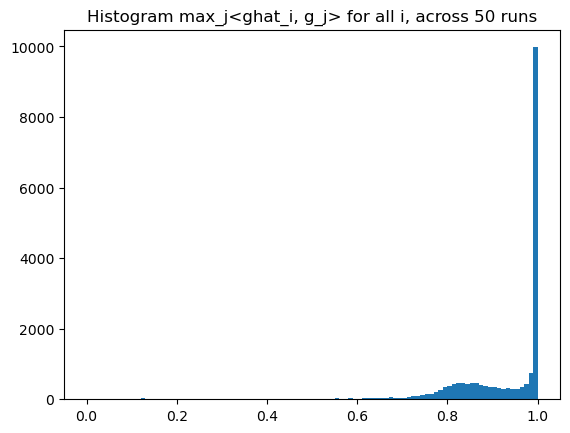

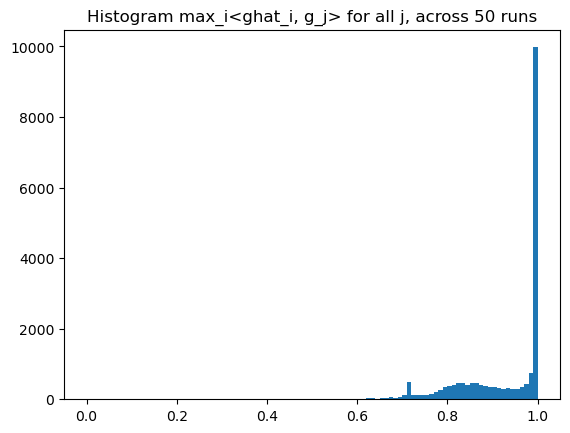

(0, 9976, 200.0, 20000, 1.0)

In [32]:
Complex_eye=torch.eye(400)#.to(device)
columns=[]
unlabeled_data=5000
locat='5kdatamodels'
decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/{locat}/'
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000, normalize=True)
decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
for curr_decoder in decoder_files:
    decoder=M.norm_linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]))  #R^ {N_k} -> C^{N_rec*N_freq}
    decoder.load_state_dict(torch.load(decoder_locats+curr_decoder))
    medium_hat=decoder(Complex_eye).squeeze()
    medium_hat=F.normalize(medium_hat, dim=-1)
    medium_hat=medium_hat.cpu().detach().numpy()
    medium_hat=H.cat2complex(medium_hat)                    
    columns.append(medium_hat)


max_inner_list=[]
maxG_inner_list=[]
index_list_list=[]



for medium_hat in columns:
    sum_max_inner_original=0      
    torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            #original way of computing inners
            # mean over true max over hats
    index_list=[]
    for i in range(400):
        if max(torch_inners[:, i])>.99 and i not in index_list:
            index_list.append(i)

        max_inner_list.append(max(torch_inners[i, :]))
        maxG_inner_list.append(max(torch_inners[:, i]))
        sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
    max_avg_inners_original=sum_max_inner_original/400
    index_list_list.append(index_list)



columns=np.array(columns)
maxG_inner_list=np.array(maxG_inner_list)
max_inner_list=np.array(max_inner_list)


print('columns shape', columns.shape)
counts, bins = np.histogram(max_inner_list, bins=[.01*i for i in range(101)])
plt.title('Histogram max_j<ghat_i, g_j> for all i, across 50 runs')
plt.hist(max_inner_list, bins=bins)
#plt.stairs(counts, bins)
#plt.hlines(np.mean(counts), xmin=0, xmax=400, color='r')
plt.show()
print(f'np.min(counts), np.max(counts), np.mean(counts), len(max_inner_list), bins[-1]: {np.min(counts), np.max(counts), np.mean(counts), len(max_inner_list), bins[-1]}')
      
counts, bins = np.histogram(maxG_inner_list, bins=[.01*i for i in range(101)])
plt.title('Histogram max_i<ghat_i, g_j> for all j, across 50 runs')
plt.hist(maxG_inner_list, bins=bins)
plt.show()
print(f'np.min(counts), np.max(counts), np.mean(counts), len(max_inner_list), bins[-1]: {np.min(counts), np.max(counts), np.mean(counts), len(max_inner_list), bins[-1]}')


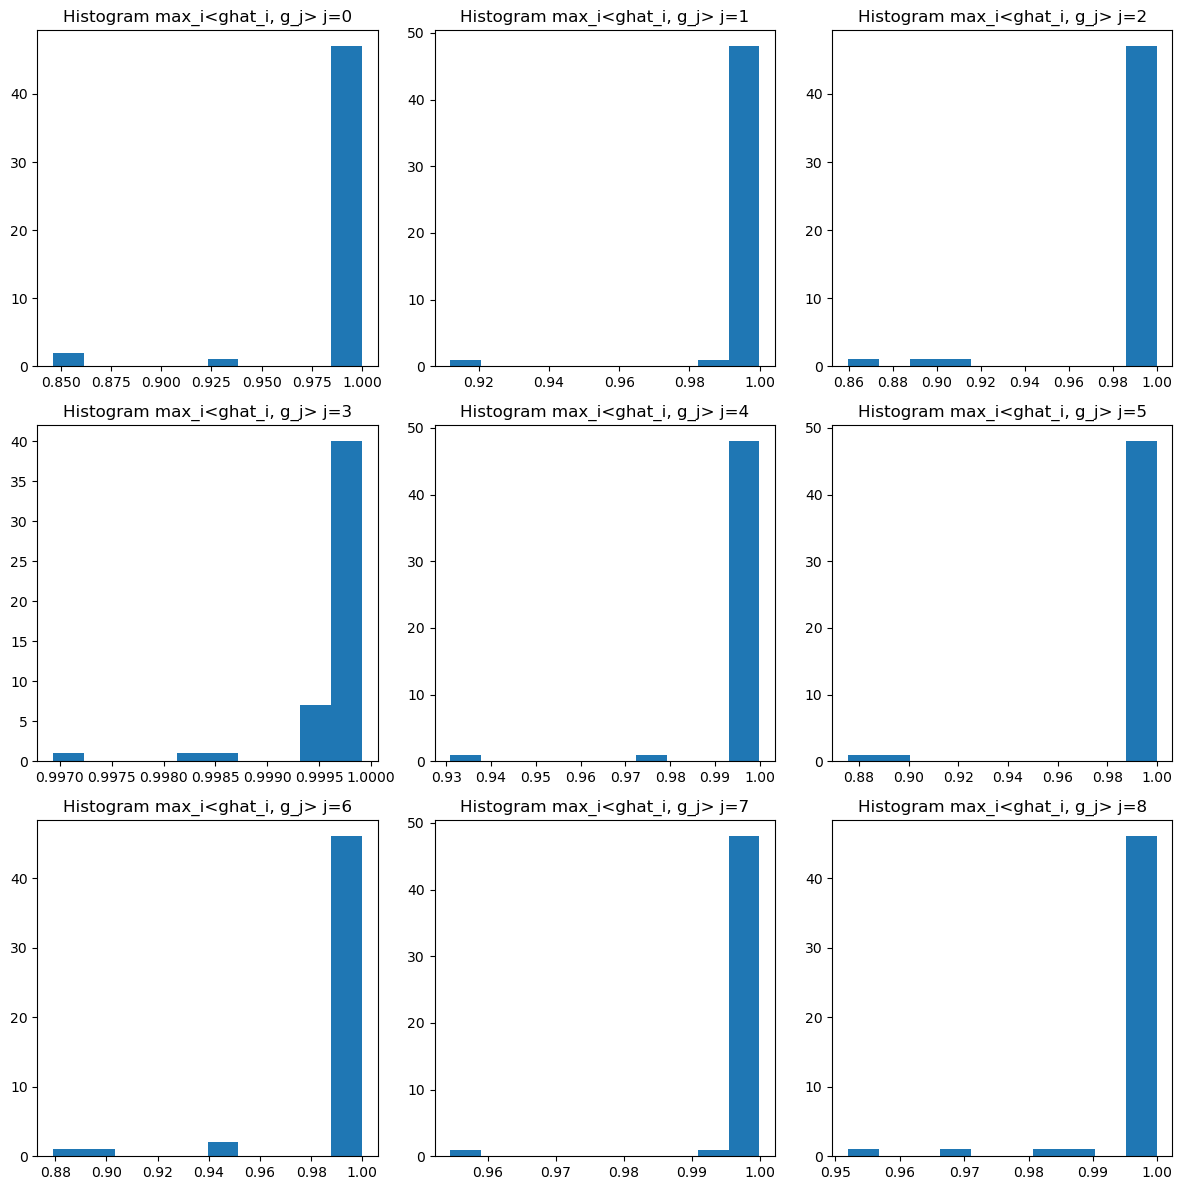

In [79]:
j=0
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for j, ax in enumerate(axs.flatten()):
    maxG_inner_list=np.array(maxG_inner_list)
    counts, bins = np.histogram(maxG_inner_list[j::400], bins=10)
    ax.set_title(f'Histogram max_i<ghat_i, g_j> j={j}')
    ax.hist(maxG_inner_list[j::400], bins=bins)

plt.tight_layout()
plt.show()



[259, 318, 250, 276, 196, 359, 318, 337, 319]
9
Medium: (1450, 400), Rho: (5000, 400), B: (5000, 1450)
[131, 166, 36, 254, 111, 203, 113, 144, 265]


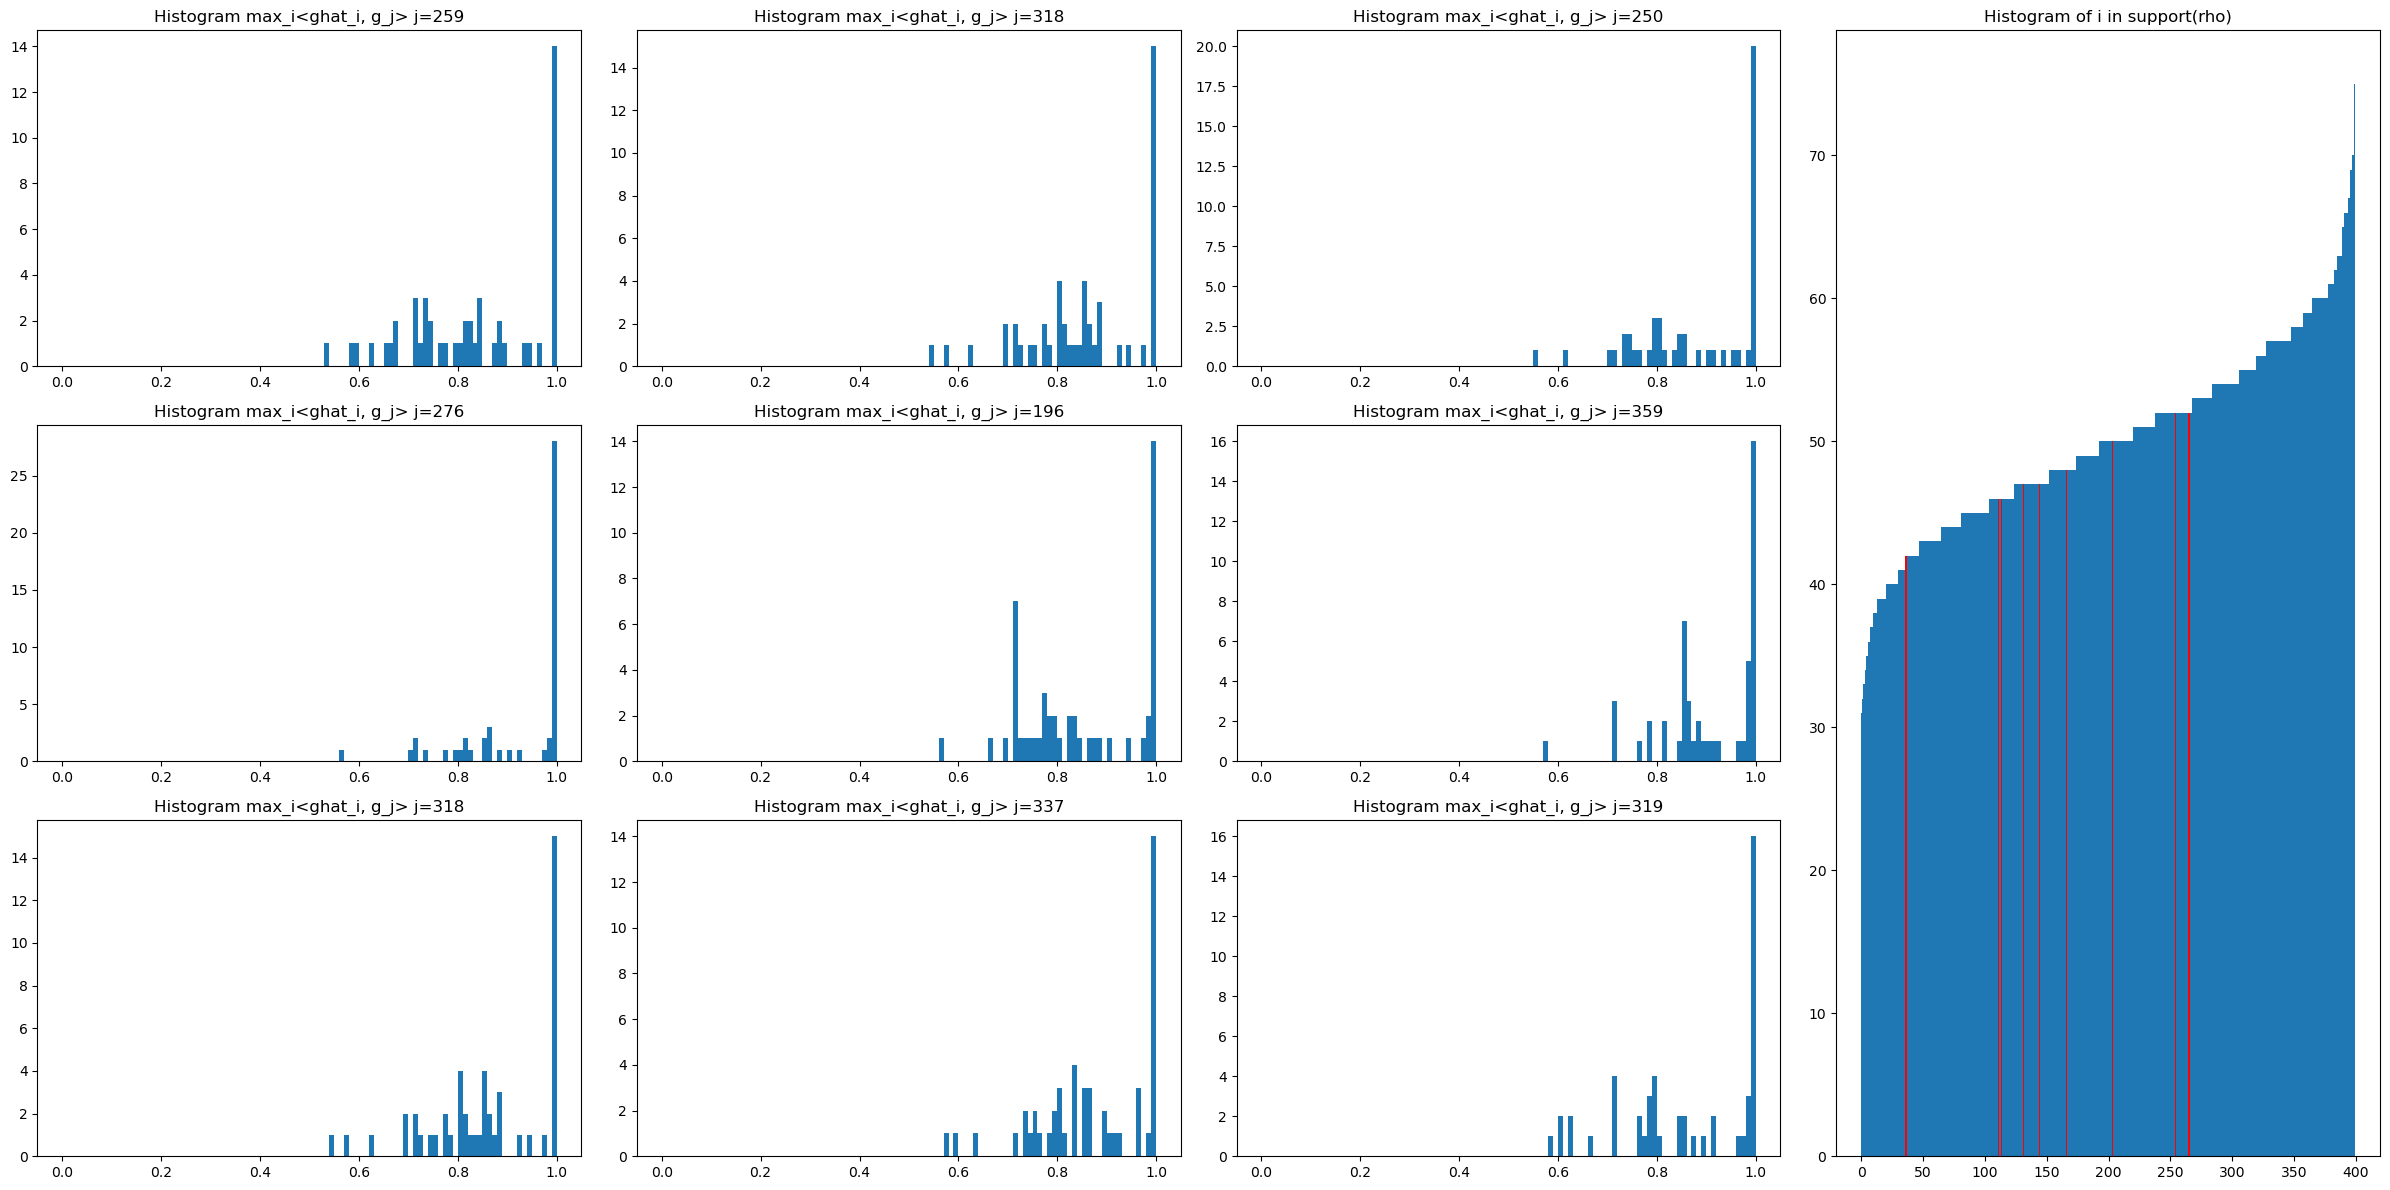

red mass: 0.0215


In [103]:
import numpy as np
import torch

import matplotlib.pyplot as plt

# Assuming maxG_inner_list and other variables are already defined

maxG_inner_list_sorted = np.sort(maxG_inner_list)
j_list = [(np.where(maxG_inner_list == i)[0][0]) % 400 for i in maxG_inner_list_sorted[:9]]
print(j_list)

fig = plt.figure(figsize=(24, 12))
gs = fig.add_gridspec(3, 4)

# Plot the first 9 subplots in a 3x3 grid
for j in range(9):
    ax = fig.add_subplot(gs[j // 3, j % 3])
    maxG_inner_list = np.array(maxG_inner_list)
    counts, bins = np.histogram(maxG_inner_list[j_list[j]::400], bins=[.01 * i for i in range(101)])
    ax.set_title(f'Histogram max_i<ghat_i, g_j> j={j_list[j]}')
    ax.hist(maxG_inner_list[j_list[j]::400], bins=bins)

# Prepare data for the 10th subplot
unlabeled_data = 5000
maxG_inner_list_sorted = np.sort(maxG_inner_list)
WORST_K = 9
j_list = []
index = -1
while len(j_list) < WORST_K:
    index = index + 1
    if (np.where(maxG_inner_list == maxG_inner_list_sorted[index])[0][0]) % 400 not in j_list:
        j_list.append((np.where(maxG_inner_list == maxG_inner_list_sorted[index])[0][0] % 400))
print(len(set(j_list)))

training_data = H.data_rho_loaded(data_path + '/train', unlabeled_data / 80000, normalize=True)
rho = training_data.rho[0]
rh, _ = torch.split(training_data.rho, 400, dim=-1)
rh_support_occ = torch.sum(rh, dim=0)

rh_support_occ = torch.sum(rh, dim=0)
rh_support_occ = rh_support_occ.cpu().detach().numpy()
worse_counts = rh_support_occ[j_list].astype(int)
j_list = np.array(j_list)
new_indices = np.argsort(rh_support_occ)
rh_support_occ.sort()
new_j_list = [np.where(new_indices == i)[0][0] for i in j_list]
print(new_j_list)

# Plot the 10th subplot
ax = fig.add_subplot(gs[:, 3])
ax.bar(range(400), rh_support_occ, width=1)
ax.bar(new_j_list, rh_support_occ[new_j_list], color='r', width=1)
ax.set_title('Histogram of i in support(rho)')

# Split the figure in half
fig.subplots_adjust(wspace=0.5)

plt.tight_layout()
plt.show()

print(f'red mass: {sum(worse_counts) / (unlabeled_data * 4)}')

Medium: (1450, 400), Rho: (5000, 400), B: (5000, 1450)
(50, 400, 1450)
(20000, 2900) float32
0.9979579
(51,)
maximum average inner product between centers and truemax_avg_inners_original 0.9159083535722472
(1450, 1450)
coherence of centers:  0.6841804
Average Cluster size: 50.0
minimum Cluster size: 15
maximum Cluster size: 80
20000
avg inner with center: 0.87567714271117
max avg inner with center: 0.9997076988220215
min avg inner with center: 0.18180549144744873
avg distance from center: 0.04634022342021466
(50, 400, 1450)


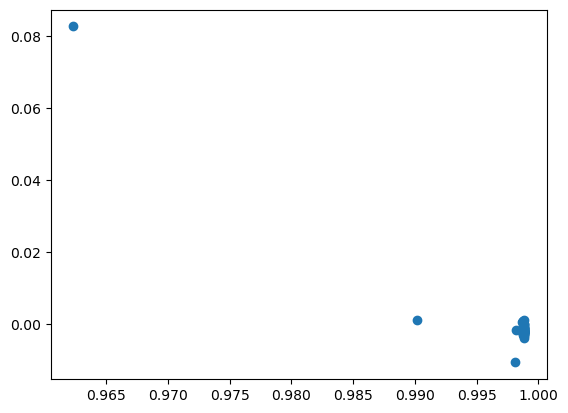

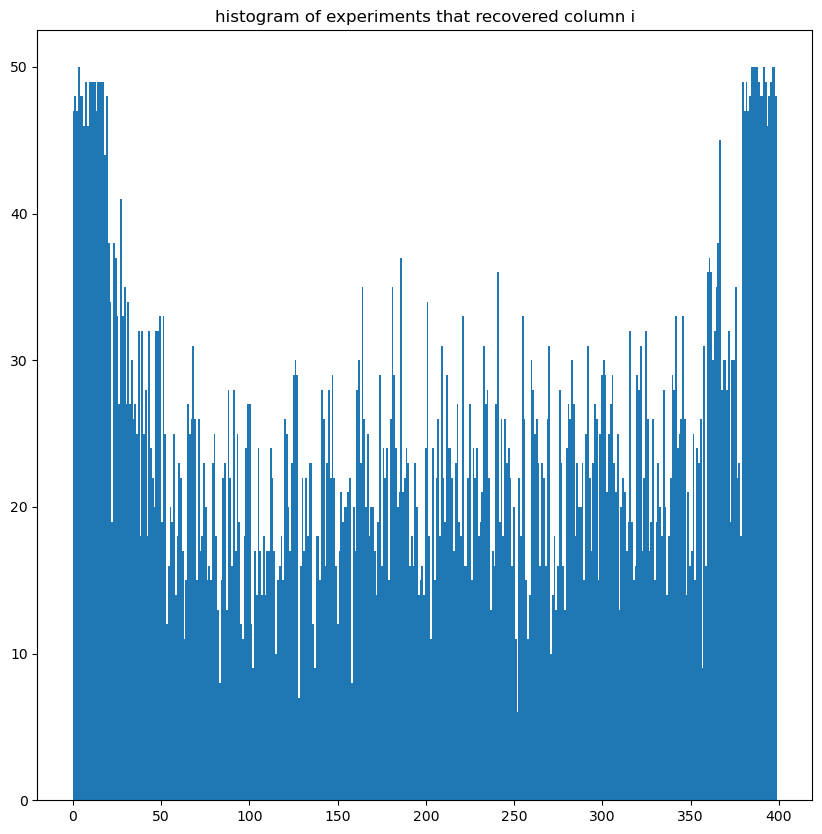

min max variances: 0.00034482762566767633, 0.00034385084290988743


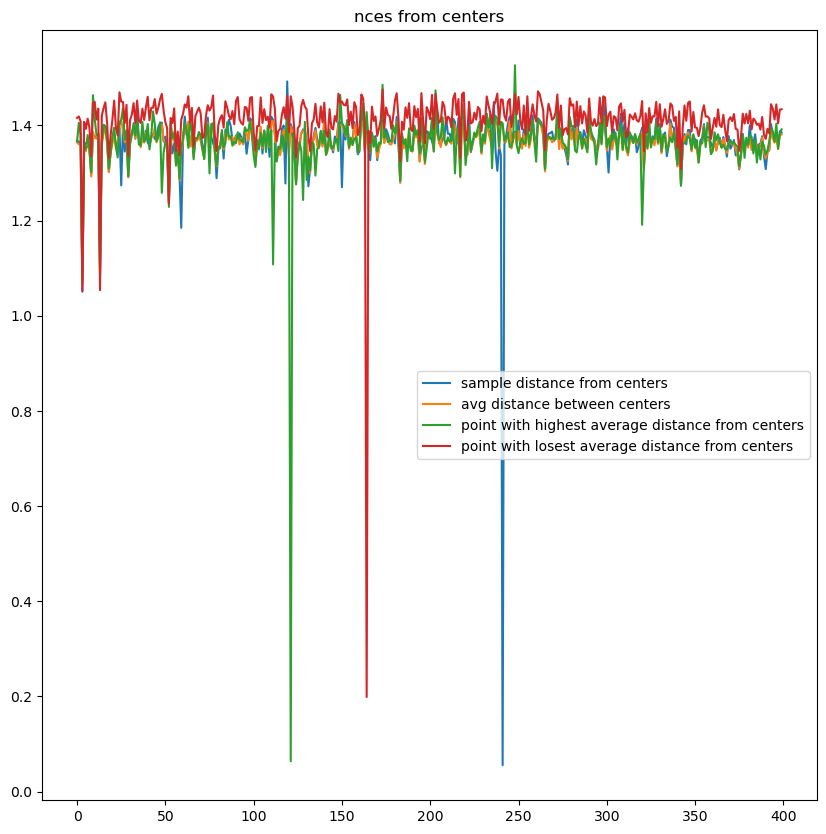

In [62]:
Complex_eye=torch.eye(400)#.to(device)
columns=[]
unlabeled_data=5000
locat='5kdatamodels'
decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/{locat}/'
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000, normalize=True)
decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
for curr_decoder in decoder_files:
    decoder=M.norm_linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]))  #R^ {N_k} -> C^{N_rec*N_freq}
    decoder.load_state_dict(torch.load(decoder_locats+curr_decoder))
    medium_hat=decoder(Complex_eye).squeeze()
    medium_hat=F.normalize(medium_hat, dim=-1)
    medium_hat=medium_hat.cpu().detach().numpy()
    medium_hat=H.cat2complex(medium_hat)                    
    columns.append(medium_hat)


index_list_list=[]



for medium_hat in columns:
    sum_max_inner_original=0      
    torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            #original way of computing inners
            # mean over true max over hats
    index_list=[]
    for i in range(400):
        if max(torch_inners[:, i])>.99 and i not in index_list:
            index_list.append(i)
        sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
    max_avg_inners_original=sum_max_inner_original/400
    index_list_list.append(index_list)
columns=np.array(columns)
print(columns.shape)
X = np.row_stack(columns)
X=np.concatenate((X.real, X.imag), axis=1)  
print(X.shape, X.dtype)
kmeans=pickle.load(open(f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/KMeans_output/{locat}.pkl', "rb"))


#graph inners of cluster
#REMARK KMEAN with dec oder initi, and random init performs much worse.
Cluster_num=99
cluster_map = pd.DataFrame()
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

CL=ClusterIndicesNumpy(Cluster_num, kmeans.labels_)
CL_center=kmeans.cluster_centers_[Cluster_num]
complex_center=H.cat2complex(CL_center)
complex_cluster=H.cat2complex(X[CL])
inners=complex_cluster.conj()@complex_center
print(np.mean(abs(inners)))
inners_cat=np.stack((inners.real, inners.imag), axis=-1)
plt.scatter(inners_cat[:,0], inners_cat[:,1])
print(inners.shape)

#STATS:

medium_hat=H.cat2complex(kmeans.cluster_centers_)
sum_max_inner_original=0      
torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
        #original way of computing inners
        # mean over true max over hats
index_list=[]
for i in range(400):
    if max(torch_inners[:, i])>.99 and i not in index_list:
        index_list.append(i)
    sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
max_avg_inners_original=sum_max_inner_original/400
print(f'maximum average inner product between centers and truemax_avg_inners_original {max_avg_inners_original}')
num_cluster_list=[len(ClusterIndicesNumpy(Cluster_num, kmeans.labels_)) for Cluster_num in range(400)]
cluster_list=[ClusterIndicesNumpy(Cluster_num, kmeans.labels_) for Cluster_num in range(400)]
centers=kmeans.cluster_centers_

complex_cluster_list=[H.cat2complex(X[CL]) for CL in cluster_list]

complex_center_list=[H.cat2complex(centers[CL]) for CL in range(400)]
inner_list=[(abs(complex_center_list[CL].conj()@complex_cluster_list[CL].T)) for CL in range(400)]
distance_list=[(np.sum((abs(complex_center_list[CL]-complex_cluster_list[CL])**2))**(1/2)) for CL in range(400)]
Avg_cluster_size=np.mean(num_cluster_list)



inners=medium_hat.transpose().conjugate()@medium_hat
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of centers: ', coherence)
print(f'Average Cluster size: {Avg_cluster_size}')
print(f'minimum Cluster size: {min(num_cluster_list)}')
print(f'maximum Cluster size: {max(num_cluster_list)}')
num_ell=sum([len(inner_list[CL]) for CL in range(400)])
print(num_ell)
print(f'avg inner with center: {sum([sum(i) for i in inner_list])/num_ell}')
print(f'max avg inner with center: {max([np.mean(i) for i in inner_list])}')
print(f'min avg inner with center: {min([np.mean(i) for i in inner_list])}')
print(f'avg distance from center: {sum(distance_list)/num_ell}') 



T_hold=.99

medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(columns.shape)
index_list_list=[]
for medium_hat in columns:
    sum_max_inner_original=0      
    torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            #original way of computing inners
            # mean over true max over hats
    index_list=[]
    for i in range(400):
        if max(torch_inners[:, i])>=T_hold and i not in index_list:
            index_list.append(i)
        sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
    max_avg_inners_original=sum_max_inner_original/400
    #print(f' max avg inners: {max_avg_inners_original}')
    index_list_list.append(index_list)
#


    

index_list_filled=[]
index_hist=[]
for j in index_list_list:
    filled=[]
    for i in range(400):
        if i in j:
            filled.append(1)
            index_hist.append(i)
        else:
            filled.append(0)
    index_list_filled.append(filled)
#col=ax.pcolor(index_list_filled)

#col = ax.pcolor(index_list_filled)
#cbar=plt.colorbar(col, ax=ax)
fig, axes=plt.subplots(nrows= 1, ncols= 1,figsize=(10,10))
axes.title.set_text('histogram of experiments that recovered column i')
counts, bins = np.histogram(index_hist, bins=400)
plt.hist(index_hist, bins=400)
#plt.stairs(counts, bins)
#plt.hlines(np.mean(counts), xmin=0, xmax=400, color='r')
plt.show()
np.min(counts), np.max(counts), np.mean(counts)
cluster_variances = []
for i in range(400):
    cluster_variances.append(np.var(X[kmeans.labels_ == i]))
print(f'min max variances: {max(cluster_variances)}, {min(cluster_variances)}')


transformed=kmeans.transform(X)
transformed.shape, X.shape
fig, axes=plt.subplots(nrows= 1, ncols= 1,figsize=(10,10))
axes.title.set_text('distance from centers')

plt.plot([i for i in range(len(transformed[0]))], transformed[99], label='sample distance from centers')
means=np.mean(transformed, axis=0)
means.shape
plt.plot([i for i in range(len(transformed[0]))], means, label='avg distance between centers')
worst_ind=np.argmax(means)
plt.plot([i for i in range(len(transformed[0]))], transformed[worst_ind], label='point with highest average distance from centers')
#plt.plot([i for i in range(len(transformed[0]))], means, label='avg distance between centers')
best_ind=np.argmin(means)
plt.plot([i for i in range(len(transformed[0]))], transformed[best_ind], label='point with losest average distance from centers')

plt.legend()

In [50]:


Complex_eye=torch.eye(400)#.to(device)
columns=[]
unlabeled_data=5000
decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/20khighcohdatamodels/'
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000, normalize=True)
decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
for curr_decoder in decoder_files:
    decoder=M.norm_linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]))  #R^ {N_k} -> C^{N_rec*N_freq}
    decoder.load_state_dict(torch.load(decoder_locats+curr_decoder))
    medium_hat=decoder(Complex_eye).squeeze()
    medium_hat=F.normalize(medium_hat, dim=-1)
    medium_hat=medium_hat.cpu().detach().numpy()
    medium_hat=H.cat2complex(medium_hat)                    
    columns.append(medium_hat)


index_list_list=[]



for medium_hat in columns:
    sum_max_inner_original=0      
    torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            #original way of computing inners
            # mean over true max overo hats
    index_list=[]
    for i in range(400):
        if max(torch_inners[:, i])>.99 and i not in index_list:
            index_list.append(i)
        sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
    max_avg_inners_original=sum_max_inner_original/400
    index_list_list.append(index_list)
columns=np.array(columns)
print(columns.shape)
X = np.row_stack(columns)
X=np.concatenate((X.real, X.imag), axis=1)  
print(X.shape, X.dtype)
kmeans=KMeans(n_clusters=400, random_state=0).fit(X)

pickle.dump(kmeans, open("/home/achristie/Codes_data/Experiment_data/rhosupport_stats/KMeans_output/20khighcohdatamodels.pkl", "wb"))


Medium: (1450, 400), Rho: (5000, 400), B: (5000, 1450)
(36, 400, 1450)
(14400, 2900) float32


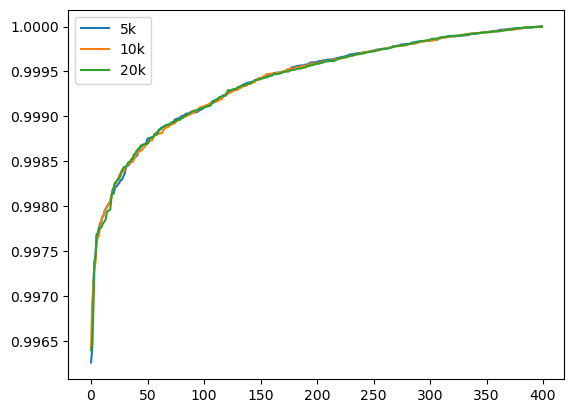

In [63]:
import pandas as pd
import pickle


modcoh5k= pickle.load(open("/home/achristie/Codes_data/Experiment_data/rhosupport_stats/KMeans_output/5kdatamodels.pkl", "rb"))
modcoh10k= pickle.load(open("/home/achristie/Codes_data/Experiment_data/rhosupport_stats/KMeans_output/10kdatamodels.pkl", "rb"))
modcoh20k= pickle.load(open("/home/achristie/Codes_data/Experiment_data/rhosupport_stats/KMeans_output/20kdatamodels.pkl", "rb"))
highcoh5k= pickle.load(open("/home/achristie/Codes_data/Experiment_data/rhosupport_stats/KMeans_output/5khighcohdatamodels.pkl", "rb"))
highcoh10k= pickle.load(open("/home/achristie/Codes_data/Experiment_data/rhosupport_stats/KMeans_output/10khighcohdatamodels.pkl", "rb"))
highcoh20k= pickle.load(open("/home/achristie/Codes_data/Experiment_data/rhosupport_stats/KMeans_output/20khighcohdatamodels.pkl", "rb"))


modcoh5k_data=(get_cluster_data('/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5kdatamodels/'))
modcoh10k_data=(get_cluster_data('/home/achristie/Codes_data/Experiment_data/rhosupport_stats/10kdatamodels/'))
modcoh20k_data=(get_cluster_data('/home/achristie/Codes_data/Experiment_data/rhosupport_stats/20kdatamodels/'))

highcoh5k_data=(get_cluster_data('/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'))
highcoh10k_data=(get_cluster_data('/home/achristie/Codes_data/Experiment_data/rhosupport_stats/10khighcohdatamodels/'))
highcoh20k_data=(get_cluster_data('/home/achristie/Codes_data/Experiment_data/rhosupport_stats/20khighcohdatamodels/'))

var_list_5k=[np.var(modcoh5k_data[modcoh5k.labels_ == i]) for i in range(400)]
var_list_10k=[np.var(modcoh10k_data[modcoh10k.labels_ == i]) for i in range(400)]
var_list_20k=[np.var(modcoh20k_data[modcoh20k.labels_ == i]) for i in range(400)]
var_list_high5k=[np.var(highcoh5k_data[highcoh5k.labels_ == i]) for i in range(400)]
var_list_high10k=[np.var(highcoh10k_data[highcoh10k.labels_ == i]) for i in range(400)]
var_list_high20k=[np.var(highcoh20k_data[highcoh20k.labels_ == i]) for i in range(400)]

maxi=max(var_list_5k)
var_list_5k.sort()
var_list_10k.sort()
var_list_20k.sort()
var_list_high5k.sort()
var_list_high10k.sort()
var_list_high20k.sort()


var_list_5k=[i/maxi for i in var_list_5k]
var_list_10k=[i/maxi for i in var_list_10k]
var_list_20k=[i/maxi for i in var_list_20k]
var_list_high5k=[i/maxi for i in var_list_high5k]
var_list_high10k=[i/maxi for i in var_list_high10k]
var_list_high20k=[i/maxi for i in var_list_high20k]
plt.plot(var_list_5k, label='5k')
plt.plot(var_list_10k, label='10k')
plt.plot(var_list_20k, label='20k')

plt.legend()

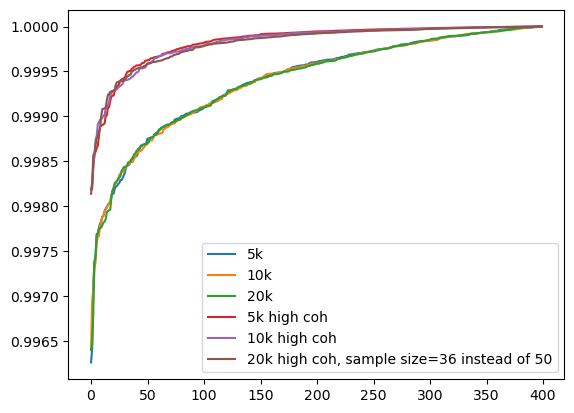

In [64]:
import pandas as pd
import pickle


modcoh5k= pickle.load(open("/home/achristie/Codes_data/Experiment_data/rhosupport_stats/KMeans_output/5kdatamodels.pkl", "rb"))
modcoh10k= pickle.load(open("/home/achristie/Codes_data/Experiment_data/rhosupport_stats/KMeans_output/10kdatamodels.pkl", "rb"))
modcoh20k= pickle.load(open("/home/achristie/Codes_data/Experiment_data/rhosupport_stats/KMeans_output/20kdatamodels.pkl", "rb"))
highcoh5k= pickle.load(open("/home/achristie/Codes_data/Experiment_data/rhosupport_stats/KMeans_output/5khighcohdatamodels.pkl", "rb"))
highcoh10k= pickle.load(open("/home/achristie/Codes_data/Experiment_data/rhosupport_stats/KMeans_output/10khighcohdatamodels.pkl", "rb"))
highcoh20k= pickle.load(open("/home/achristie/Codes_data/Experiment_data/rhosupport_stats/KMeans_output/20khighcohdatamodels.pkl", "rb"))


modcoh5k_data=(get_cluster_data('/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5kdatamodels/'))
modcoh10k_data=(get_cluster_data('/home/achristie/Codes_data/Experiment_data/rhosupport_stats/10kdatamodels/'))
modcoh20k_data=(get_cluster_data('/home/achristie/Codes_data/Experiment_data/rhosupport_stats/20kdatamodels/'))

highcoh5k_data=(get_cluster_data('/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'))
highcoh10k_data=(get_cluster_data('/home/achristie/Codes_data/Experiment_data/rhosupport_stats/10khighcohdatamodels/'))
highcoh20k_data=(get_cluster_data('/home/achristie/Codes_data/Experiment_data/rhosupport_stats/20khighcohdatamodels/'))

var_list_5k=[np.var(modcoh5k_data[modcoh5k.labels_ == i]) for i in range(400)]
var_list_10k=[np.var(modcoh10k_data[modcoh10k.labels_ == i]) for i in range(400)]
var_list_20k=[np.var(modcoh20k_data[modcoh20k.labels_ == i]) for i in range(400)]
var_list_high5k=[np.var(highcoh5k_data[highcoh5k.labels_ == i]) for i in range(400)]
var_list_high10k=[np.var(highcoh10k_data[highcoh10k.labels_ == i]) for i in range(400)]
var_list_high20k=[np.var(highcoh20k_data[highcoh20k.labels_ == i]) for i in range(400)]

maxi=max(var_list_5k)
var_list_5k.sort()
var_list_10k.sort()
var_list_20k.sort()
var_list_high5k.sort()
var_list_high10k.sort()
var_list_high20k.sort()


var_list_5k=[i/maxi for i in var_list_5k]
var_list_10k=[i/maxi for i in var_list_10k]
var_list_20k=[i/maxi for i in var_list_20k]
var_list_high5k=[i/maxi for i in var_list_high5k]
var_list_high10k=[i/maxi for i in var_list_high10k]
var_list_high20k=[i/maxi for i in var_list_high20k]
plt.plot(var_list_5k, label='5k')
plt.plot(var_list_10k, label='10k')
plt.plot(var_list_20k, label='20k')
plt.plot(var_list_high5k, label='5k high coh')
plt.plot(var_list_high10k, label='10k high coh')
plt.plot(var_list_high20k, label='20k high coh, sample size=36 instead of 50')
plt.legend()

In [53]:
highcoh20k.labels_.shape

(14400,)

,coherence of centers,Average Cluster size,minimum Cluster size,maximum Cluster size,avg inner with center,max avg inner with center,avg distance from center,max average inner product between centers and truemax_avg_inners_original
5kdatamodels,0.684180,50.0,15.0,80.0,0.875677,0.999708,0.046340,0.915908
10kdatamodels,0.492986,50.0,6.0,123.0,0.295473,0.716367,0.163602,0.924479
20kdatamodels,0.523137,50.0,12.0,91.0,0.297598,0.637212,0.164650,0.937102


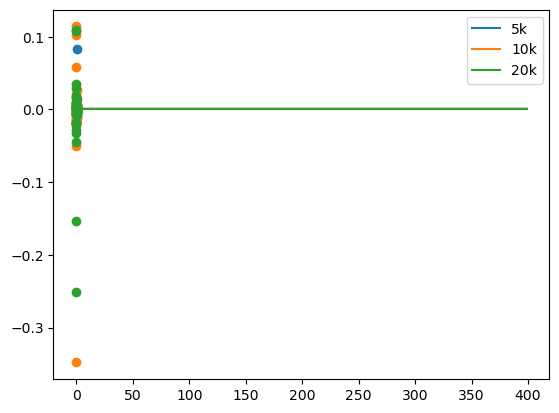

In [60]:
import pandas as pd
import pickle

modcoh5k= pickle.load(open("/home/achristie/Codes_data/Experiment_data/rhosupport_stats/KMeans_output/5kdatamodels.pkl", "rb"))
modcoh10k= pickle.load(open("/home/achristie/Codes_data/Experiment_data/rhosupport_stats/KMeans_output/10kdatamodels.pkl", "rb"))
modcoh20k= pickle.load(open("/home/achristie/Codes_data/Experiment_data/rhosupport_stats/KMeans_output/20kdatamodels.pkl", "rb"))
highcoh5k= pickle.load(open("/home/achristie/Codes_data/Experiment_data/rhosupport_stats/KMeans_output/5khighcohdatamodels.pkl", "rb"))
modcoh5k_data=(get_cluster_data('/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5kdatamodels/'))
modcoh10k_data=(get_cluster_data('/home/achristie/Codes_data/Experiment_data/rhosupport_stats/10kdatamodels/'))
modcoh20k_data=(get_cluster_data('/home/achristie/Codes_data/Experiment_data/rhosupport_stats/20kdatamodels/'))
highcoh5k_data=(get_cluster_data('/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'))

var_list_5k=[np.var(modcoh5k_data[modcoh5k.labels_ == i]) for i in range(400)]
var_list_10k=[np.var(modcoh10k_data[modcoh10k.labels_ == i]) for i in range(400)]
var_list_20k=[np.var(modcoh20k_data[modcoh20k.labels_ == i]) for i in range(400)]
var_list_high5k=[np.var(highcoh5k_data[highcoh5k.labels_ == i]) for i in range(400)]
maxi=1#max(var_list_5k)
var_list_5k.sort()
var_list_10k.sort()
var_list_20k.sort()
var_list_high5k.sort()
var_list_5k=[i/maxi for i in var_list_5k]
var_list_10k=[i/maxi for i in var_list_10k]
var_list_20k=[i/maxi for i in var_list_20k]
var_list_high5k=[i/maxi for i in var_list_high5k]
plt.plot(var_list_5k, label='5k')
plt.plot(var_list_10k, label='10k')
plt.plot(var_list_20k, label='20k')
#plt.plot(var_list_high5k, label='5k high coh')
plt.legend()

df=pd.DataFrame(columns=['coherence of centers', 'Average Cluster size', 'minimum Cluster size', 'maximum Cluster size', 'avg inner with center', 'max avg inner with center', 'avg distance from center', 'max average inner product between centers and truemax_avg_inners_original'])



def print_stats(kmeans, locat):
    columns=get_cluster_data('/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5kdatamodels/')
    X = np.row_stack(columns)
    X=np.concatenate((X.real, X.imag), axis=1)  


    #graph inners of cluster
    #REMARK KMEAN with dec oder initi, and random init performs much worse.
    Cluster_num=99
    cluster_map = pd.DataFrame()
    def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
        return np.where(labels_array == clustNum)[0]

    CL=ClusterIndicesNumpy(Cluster_num, kmeans.labels_)
    CL_center=kmeans.cluster_centers_[Cluster_num]
    complex_center=H.cat2complex(CL_center)
    complex_cluster=H.cat2complex(X[CL])
    inners=complex_cluster.conj()@complex_center
    inners_cat=np.stack((inners.real, inners.imag), axis=-1)
    plt.scatter(inners_cat[:,0], inners_cat[:,1])

    #STATS:

    medium_hat=H.cat2complex(kmeans.cluster_centers_)
    sum_max_inner_original=0      
    torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            #original way of computing inners
            # mean over true max over hats
    index_list=[]
    for i in range(400):
        if max(torch_inners[:, i])>.99 and i not in index_list:
            index_list.append(i)
        sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
    max_avg_inners_original=sum_max_inner_original/400
    num_cluster_list=[len(ClusterIndicesNumpy(Cluster_num, kmeans.labels_)) for Cluster_num in range(400)]
    cluster_list=[ClusterIndicesNumpy(Cluster_num, kmeans.labels_) for Cluster_num in range(400)]
    centers=kmeans.cluster_centers_

    complex_cluster_list=[H.cat2complex(X[CL]) for CL in cluster_list]

    complex_center_list=[H.cat2complex(centers[CL]) for CL in range(400)]
    inner_list=[(abs(complex_center_list[CL].conj()@complex_cluster_list[CL].T)) for CL in range(400)]
    distance_list=[(np.sum((abs(complex_center_list[CL]-complex_cluster_list[CL])**2))**(1/2)) for CL in range(400)]
    Avg_cluster_size=np.mean(num_cluster_list)



    inners=medium_hat.transpose().conjugate()@medium_hat
    coherence=0
    for i in inners:
        for j in i:
            if abs(j)>coherence and j<.99:
                coherence=abs(j)
    num_ell=sum([len(inner_list[CL]) for CL in range(400)])



    df_row=locat.split('/')[-2]

    df.loc[df_row]=[coherence, Avg_cluster_size, min(num_cluster_list), max(num_cluster_list), sum([sum(i) for i in inner_list])/num_ell, max([np.mean(i) for i in inner_list]), sum(distance_list)/num_ell, max_avg_inners_original]


print_stats(modcoh5k, '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5kdatamodels/')
print_stats(modcoh10k, '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/10kdatamodels/')
print_stats(modcoh20k, '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/20kdatamodels/')
df


In [13]:
modcoh5k.labels_[:5],modcoh10k.labels_[:5]

(array([ 35, 328, 240, 164, 129], dtype=int32),
 array([266, 253,  61, 179, 258], dtype=int32))

In [7]:
modcoh5k_data.shape

AttributeError: 'list' object has no attribute 'shape'

Medium: (1450, 400), Rho: (5000, 400), B: (5000, 1450)
(50, 400, 1450)
(20000, 2900) float32
0.84293675
(50,)
maximum average inner product between centers and truemax_avg_inners_original 0.9371016575886572
(1450, 1450)
coherence of centers:  0.5231369
Average Cluster size: 50.0
minimum Cluster size: 12
maximum Cluster size: 91
20000
avg inner with center: 0.8932139142807574
max avg inner with center: 0.9998466372489929
min avg inner with center: 0.18243058025836945
avg distance from center: 0.042163705990268745
(50, 400, 1450)


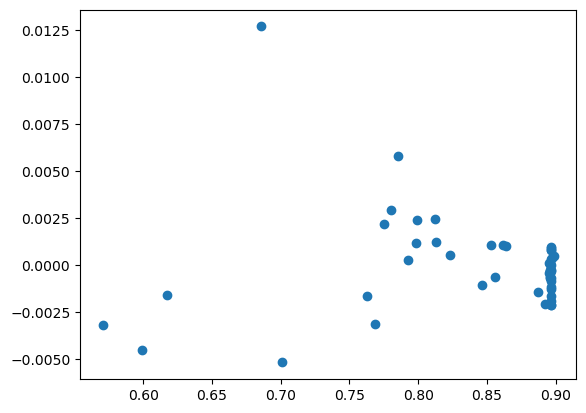

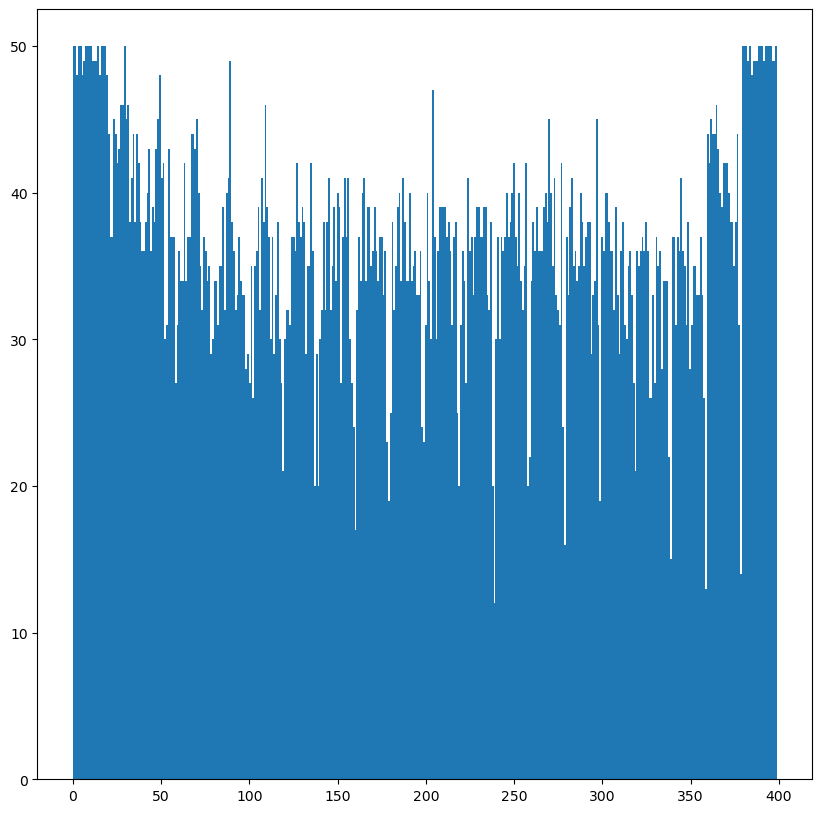

min max variances: 0.00034482762566767633, 0.0003437390550971031


In [35]:

Complex_eye=torch.eye(400)#.to(device)
columns=[]
unlabeled_data=5000
decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/10khighcohdatamodels/'
decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/10khighcohdatamodels/'
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000, normalize=True)
decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
for curr_decoder in decoder_files:
    decoder=M.norm_linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]))  #R^ {N_k} -> C^{N_rec*N_freq}
    decoder.load_state_dict(torch.load(decoder_locats+curr_decoder))
    medium_hat=decoder(Complex_eye).squeeze()
    medium_hat=F.normalize(medium_hat, dim=-1)
    medium_hat=medium_hat.cpu().detach().numpy()
    medium_hat=H.cat2complex(medium_hat)                    
    columns.append(medium_hat)


index_list_list=[]



for medium_hat in columns:
    sum_max_inner_original=0      
    torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            #original way of computing inners
            # mean over true max over hats
    index_list=[]
    for i in range(400):
        if max(torch_inners[:, i])>.99 and i not in index_list:
            index_list.append(i)
        sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
    max_avg_inners_original=sum_max_inner_original/400
    index_list_list.append(index_list)
columns=np.array(columns)
print(columns.shape)
X = np.row_stack(columns)
X=np.concatenate((X.real, X.imag), axis=1)  
print(X.shape, X.dtype)
kmeans=KMeans(n_clusters=400, random_state=0).fit(X)


#graph inners of cluster
#REMARK KMEAN with dec oder initi, and random init performs much worse.
Cluster_num=99
cluster_map = pd.DataFrame()
def ClusterIndicesNumpy(clustNum, labels_array): #numpy 
    return np.where(labels_array == clustNum)[0]

CL=ClusterIndicesNumpy(Cluster_num, kmeans.labels_)
CL_center=kmeans.cluster_centers_[Cluster_num]
complex_center=H.cat2complex(CL_center)
complex_cluster=H.cat2complex(X[CL])
inners=complex_cluster.conj()@complex_center
print(np.mean(abs(inners)))
inners_cat=np.stack((inners.real, inners.imag), axis=-1)
plt.scatter(inners_cat[:,0], inners_cat[:,1])
print(inners.shape)

#STATS:

medium_hat=H.cat2complex(kmeans.cluster_centers_)
sum_max_inner_original=0      
torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
        #original way of computing inners
        # mean over true max over hats
index_list=[]
for i in range(400):
    if max(torch_inners[:, i])>.99 and i not in index_list:
        index_list.append(i)
    sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
max_avg_inners_original=sum_max_inner_original/400
print(f'maximum average inner product between centers and truemax_avg_inners_original {max_avg_inners_original}')
num_cluster_list=[len(ClusterIndicesNumpy(Cluster_num, kmeans.labels_)) for Cluster_num in range(400)]
cluster_list=[ClusterIndicesNumpy(Cluster_num, kmeans.labels_) for Cluster_num in range(400)]
centers=kmeans.cluster_centers_

complex_cluster_list=[H.cat2complex(X[CL]) for CL in cluster_list]

complex_center_list=[H.cat2complex(centers[CL]) for CL in range(400)]
inner_list=[(abs(complex_center_list[CL].conj()@complex_cluster_list[CL].T)) for CL in range(400)]
distance_list=[(np.sum((abs(complex_center_list[CL]-complex_cluster_list[CL])**2))**(1/2)) for CL in range(400)]
Avg_cluster_size=np.mean(num_cluster_list)



inners=medium_hat.transpose().conjugate()@medium_hat
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of centers: ', coherence)
print(f'Average Cluster size: {Avg_cluster_size}')
print(f'minimum Cluster size: {min(num_cluster_list)}')
print(f'maximum Cluster size: {max(num_cluster_list)}')
num_ell=sum([len(inner_list[CL]) for CL in range(400)])
print(num_ell)
print(f'avg inner with center: {sum([sum(i) for i in inner_list])/num_ell}')
print(f'max avg inner with center: {max([np.mean(i) for i in inner_list])}')
print(f'min avg inner with center: {min([np.mean(i) for i in inner_list])}')
print(f'avg distance from center: {sum(distance_list)/num_ell}') 



T_hold=.99

medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(columns.shape)
index_list_list=[]
for medium_hat in columns:
    sum_max_inner_original=0      
    torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            #original way of computing inners
            # mean over true max over hats
    index_list=[]
    for i in range(400):
        if max(torch_inners[:, i])>=T_hold and i not in index_list:
            index_list.append(i)
        sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
    max_avg_inners_original=sum_max_inner_original/400
    #print(f' max avg inners: {max_avg_inners_original}')
    index_list_list.append(index_list)
#


    

index_list_filled=[]
index_hist=[]
for j in index_list_list:
    filled=[]
    for i in range(400):
        if i in j:
            filled.append(1)
            index_hist.append(i)
        else:
            filled.append(0)
    index_list_filled.append(filled)
fig, axes=plt.subplots(nrows= 1, ncols= 1,figsize=(10,10))
axes.title.set_text('Sample Clusterr. Distance from centers')
ax=axes
#col=ax.pcolor(index_list_filled)

#col = ax.pcolor(index_list_filled)
#cbar=plt.colorbar(col, ax=ax)
fig, axes=plt.subplots(nrows= 1, ncols= 1,figsize=(10,10))
axes.title.set_text('histogram of experiments that recovered column i')
counts, bins = np.histogram(index_hist, bins=400)
plt.hist(index_hist, bins=400)
#plt.stairs(counts, bins)
#plt.hlines(np.mean(counts), xmin=0, xmax=400, color='r')
plt.show()
np.min(counts), np.max(counts), np.mean(counts)
cluster_variances = []
for i in range(400):
    cluster_variances.append(np.var(X[kmeans.labels_ == i]))
print(f'min max variances: {max(cluster_variances)}, {min(cluster_variances)}')


transformed=kmeans.transform(X)
transformed.shape, X.shape
fig, axes=plt.subplots(nrows= 1, ncols= 1,figsize=(10,10))
axes.title.set_text('nces from centers')

plt.plot([i for i in range(len(transformed[0]))], transformed[99], label='sample distance from centers')
means=np.mean(transformed, axis=0)
means.shape
plt.plot([i for i in range(len(transformed[0]))], means, label='avg distance between centers')
worst_ind=np.argmax(means)
plt.plot([i for i in range(len(transformed[0]))], transformed[worst_ind], label='point with highest average distance from centers')
#plt.plot([i for i in range(len(transformed[0]))], means, label='avg distance between centers')
best_ind=np.argmin(means)
plt.plot([i for i in range(len(transformed[0]))], transformed[best_ind], label='point with losest average distance from centers')

plt.legend()


In [28]:
cluster_variances = []
for i in range(3):
    cluster_variances.append(np.var(X[kmeans.label == i]))
print(min(cluster_variances))

NameError: name 'labels' is not defined

In [32]:
cluster_variances = []
for i in range(400):
    cluster_variances.append(np.var(X[kmeans.labels_ == i]))
print(max(cluster_variances))

0.00034482763


In [48]:
import shutil
import os
import fnmatch

timestamps = [ '08-22-27', '08-17-55', '08-17-39', '05-56-00', '05-51-10', '05-50-38', '03-29-16', '03-24-40', '03-23-10', '01-02-21', '00-57-52', '00-55-45', '23-13-42', '23-10-55', '23-09-21', '21-28-07', '21-25-54', '21-24-32', '19-42-42', '19-40-47', '19-39-40', '17-57-09', '17-55-26', '17-54-30', '16-14-49', '16-13-45', '16-12-37', '14-21-24', '14-20-38', '14-19-25', '12-15-14', '12-14-22', '12-13-43', '10-14-23', '10-13-39', '10-13-26' ]

# Original directory
directory = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/10khighcohdatamodels/'

# New directory to move the files to
new_directory = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/20khighcohdatamodels/'

# Ensure the new directory exists
os.makedirs(new_directory, exist_ok=True)

# List to hold the incorrect locations
incorrect_locat = []

# Search for files with the specified timestamps in their names
for root, dirs, files in os.walk(directory):
    for timestamp in timestamps:
        for filename in fnmatch.filter(files, f"*{timestamp}*"):
            file_path = os.path.join(root, filename)
            incorrect_locat.append(file_path)
            # Move each file to the new directory
            shutil.move(file_path, os.path.join(new_directory, filename))

# Print the number of files moved
print(f"Moved {len(incorrect_locat)} files.")

Moved 72 files.


In [ ]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=.5, min_samples=15).fit(X)

len(set(clustering.labels_))

390

In [4]:
torch.manual_seed(47)
unlabeled_data=5000
training_data_1=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000, normalize=True)
torch.manual_seed(49)
training_data_2=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000, normalize=True)
torch.allclose(training_data_1.b, training_data_2.b)

Medium: (1450, 400), Rho: (5000, 400), B: (5000, 1450)
Medium: (1450, 400), Rho: (5000, 400), B: (5000, 1450)


True

(50, 400, 1450)


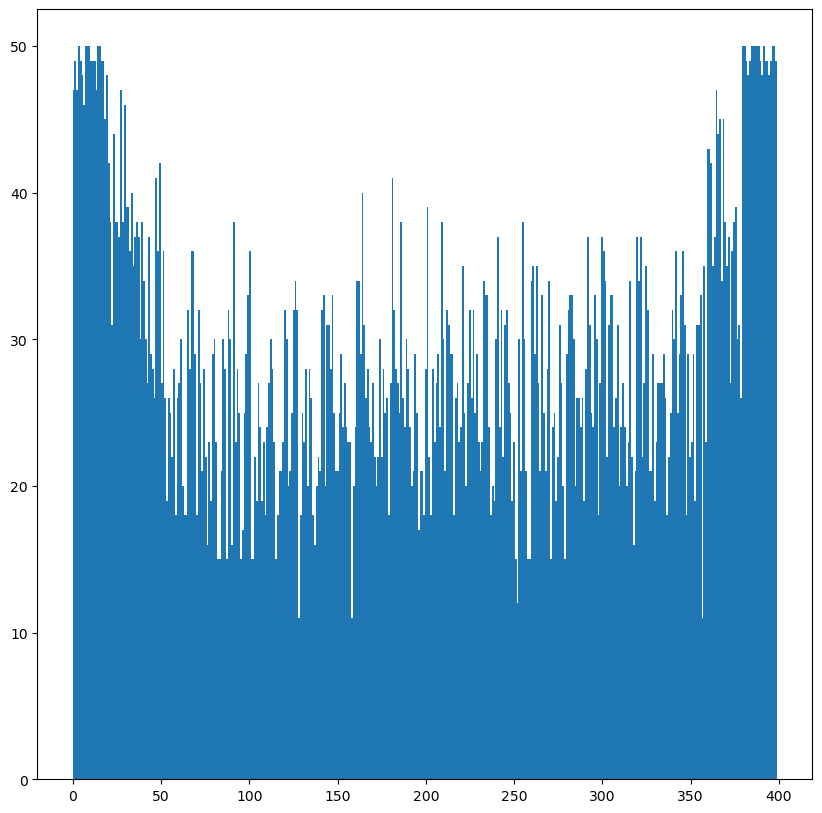

(11, 50, 29.5275)

In [11]:

T_hold=.95

medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(columns.shape)
index_list_list=[]
for medium_hat in columns:
    sum_max_inner_original=0      
    torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
            #original way of computing inners
            # mean over true max over hats
    index_list=[]
    for i in range(400):
        if max(torch_inners[:, i])>=T_hold and i not in index_list:
            index_list.append(i)
        sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
    max_avg_inners_original=sum_max_inner_original/400
    #print(f' max avg inners: {max_avg_inners_original}')
    index_list_list.append(index_list)
#


    

index_list_filled=[]
index_hist=[]
for j in index_list_list:
    filled=[]
    for i in range(400):
        if i in j:
            filled.append(1)
            index_hist.append(i)
        else:
            filled.append(0)
    index_list_filled.append(filled)
fig, axes=plt.subplots(nrows= 1, ncols= 1,figsize=(10,10))

ax=axes
#col=ax.pcolor(index_list_filled)

#col = ax.pcolor(index_list_filled)
#cbar=plt.colorbar(col, ax=ax)
counts, bins = np.histogram(index_hist, bins=400)
plt.hist(index_hist, bins=400)
#plt.stairs(counts, bins)
#plt.hlines(np.mean(counts), xmin=0, xmax=400, color='r')
plt.show()
np.min(counts), np.max(counts), np.mean(counts)

In [2]:
#Raw data unlabeled 
starttime=time.time()
target='raw'
unlabeled_data=5000
batchsize=128
L1_weight=1e-3
THRESH_HOLD_VAL=.01
layers=[512,256]
#[500,500,500,300,300,400,800]#[3000,1000,500,300,300,300,300,300,300,300,300,300,300,300]#[3000,1500,1000,500,500,500,300,300,300,400,400,800]#[1000,1000,1000,500,500,500,300,300,300,400,400,400,800]
GELMA_layers=layers#[500,500,500,300,300,400,800]
CE=False
KM_in=False
INV_weight=0
RESHUFFLE=False
LR=1e-3
GELMA=1e-3
TIME_reverse=False
E_list=0
RESETS=0
GELMA_MAX=.5
GELMA_inc=0
G_0=True
Epochs=300000
index_list=[]
GELMA_MAX=.5
GELMA_inc=0
G_0=True
index_list=[]
GELMA_MAX=.5
GELMA_inc=0
data_path=os.path.join(cwd,'Data/PNAS-regime_all_seeds/PNAS-regime_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)


Track_run=False
#Enter your wanbd key below and uncomment wanbd code to track run on wandb
if Track_run:
    key='89a70fbc572a495206df640bd6c9cbf2a4a0dcaa' #enter your own key here
    wandb.login(key=key) 
    wandb.init(project='rtt unlabeled', name="Unlabeled data: 40000, small net softmax")


    wandb.config['unlabeled_data']=unlabeled_data 
    wandb.config['L1_weight']=L1_weight
    wandb.config['layers']=layers
    wandb.config['GELMA']=GELMA
    wandb.config['G_0']=G_0
    wandb.config['GELMA_layers']=GELMA_layers   
    wandb.config['inv_weight']=INV_weight
    wandb.config['CE']=CE
wand_dict={}
#GELMA_layers.append(500)
#layers.append(500)
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000, normalize=True)
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
sigmoid = nn.Sigmoid()
softmax=nn.Softmax(dim=0)
#training_data.b=training_data.b.to(device)
#training_data.rho=training_data.rho.to(device)
#rh_t, _=torch.split(rho, 400, dim=-1)


val_data=H.data_rho_loaded(data_path+'/val', 3000/80000, normalize=True)
b_val=val_data.b.to(device)
rho_val=val_data.rho.to(device)
rh_v, _=torch.split(rho_val, 400, dim=-1)
indim=int(training_data.b[0].shape[0]/2)
outdim=int(training_data.rho[0].shape[0]/4)
enc_dim=training_data.b[0].shape[0]/2
if KM_in:
    enc_dim=enc_dim+outdim*2
decoder_hats=[]
encoder=M.fc_net_extra(enc_dim, layers,outdim, net_type='fc',linear_type='real', activation='leaky', bias=True, out_scaling=None,dropout=.5)
encoder=M.channeled_lin_layers(enc_dim, layers, outdim*2, dropout=.5)
print(H.count_parameters(encoder))
#decoder=nn.Linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), bias=False)  #R^ {N_k} -> C^{N_rec*N_freq}
decoder=M.norm_linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]))  #R^ {N_k} -> C^{N_rec*N_freq}
#decoder=M.fc_net_extra(outdim, layers[::-1], indim, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5)
if G_0:
    #G_0_w=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
    G_0_w=(np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt']))
    
    G_0_w=torch.cat((torch.tensor(G_0_w.real), torch.tensor(G_0_w.imag)), dim=0)
    G_0_w=G_0_w.float()
    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))
    Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1)
    medium_hat=decoder(Complex_eye).squeeze()
    medium_hat=F.normalize(medium_hat, dim=-1)
    print(f'G_0 initialization successful: {torch.allclose(medium_hat, G_0_w.T)}')


print(H.count_parameters(encoder))
print('Data shapes:', training_data.b[0].shape[0]/2, training_data.rho[0].shape[0]/4)
encoder.to(device)
decoder.to(device)
relu=nn.ReLU()
leaky_relu=nn.LeakyReLU(THRESH_HOLD_VAL)
optimizer = torch.optim.AdamW(encoder.parameters(), lr=LR)
optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=LR)


tanh=nn.Tanh()
softmax=nn.Softmax(dim=1)
bce_loss_fn=nn.BCELoss() 
Threshold=nn.Threshold(THRESH_HOLD_VAL, 0)  
L2_loss_fn=nn.MSELoss()
CE_loss_fn=nn.CrossEntropyLoss()
L2_loss_fn=lambda x,y: torch.sqrt(nn.MSELoss()(x,y))
L1_loss_fn=nn.L1Loss()
Complex_eye=torch.eye(int(outdim*2)).unsqueeze(1).to(device)
softmax=nn.Softmax(dim=1)
if GELMA>0:
    GELMA_net=M.fc_net_batch(training_data.b[0].shape[0]/2, GELMA_layers, training_data.b[0].shape[0]/2, net_type='fc',linear_type='real', activation='leaky', bias=True, out_scaling=None, dropout=.5)
    optimizer_GELMA = torch.optim.AdamW(GELMA_net.parameters(), lr=LR, maximize=True)
    GELMA_net.to(device)
    #GELMA_net=nn.DataParallel(GELMA_net)
    GELMA_net.train()
def f_col(batch):
    b=torch.stack([item[0] for item in batch])
    rho=torch.stack([item[1] for item in batch])
    num_targets=torch.stack([item[2] for item in batch])
    return b.to(device), rho.to(device), num_targets


def rescale_rho(z):
    minimum, _=torch.min(z, -1, keepdim=True)
    maxium, _=torch.max(z, -1,   keepdim=True)
    z=(z-minimum)/(maxium-minimum)
    return z
lr_scheduler_enc=torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.995, last_epoch=-1)
lr_scheduler_decod=torch.optim.lr_scheduler.ExponentialLR(optimizer_decod, gamma=.995, last_epoch=-1)
trainloader=DataLoader(training_data,batch_size=batchsize,shuffle=True,num_workers=0)
if E_list>0:
    encs=[M.fc_net_extra(enc_dim, layers,outdim, net_type='fc',linear_type='real', activation='relu', bias=True, out_scaling=None,dropout=.5) for i in range(E_list)]
    opts=[torch.optim.AdamW(enc.parameters(), lr=LR) for enc in encs]
    for enc in encs:
        enc.to(device)
for epoch in range(Epochs):
    if RESETS>0 and epoch%RESETS==0:
        #decoder=M.norm_linear(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]))  #R^ {N_k} -> C^{N_rec*N_freq}
        #if G_0:
        #    G_0=(np.array(mat73.loadmat(data_path+'/G_0.mat')['A0']))
        #    G_0_w=torch.cat((torch.tensor(G_0.real), torch.tensor(G_0.imag)), dim=0)
        #    G_0_w=G_0_w.float()
        #    decoder.weight.data=nn.parameter.Parameter(G_0_w.clone().detach().requires_grad_(True))
        #    decoder.to(device)
        #    medium_hat=decoder(Complex_eye).squeeze()
        #    medium_hat=F.normalize(medium_hat, dim=-1)
        #encoder=M.fc_net_extra(enc_dim, layers,outdim, net_type='fc',linear_type='complex', activation='mod_relu', bias=True, out_scaling=None,dropout=.5)
        encoder=M.channeled_lin_layers(enc_dim, layers, outdim*2, dropout=.5)
        encoder.to(device)
        optimizer = torch.optim.AdamW(encoder.parameters(), lr=LR)
        optimizer_decod = torch.optim.AdamW(decoder.parameters(), lr=LR)
    train_lossavg=0
    train_lossavg=0
    L1_loss_avg=0
    coupled_grad=0
    project_grad=0
    INV_loss_avg=0
    CEloss_avg=0


    inner_loss_term_avg=0
    for batch, (b, rho, num_targets) in enumerate(trainloader):
        if True:
            b=b.to(device)
            rho=rho.to(device)
            optimizer.zero_grad()
            optimizer_decod.zero_grad()
            if E_list>0:
                for enc in encs:
                    enc.zero_grad()
            if KM_in:
                medium_hat=decoder(Complex_eye).squeeze()
                medium_hat=F.normalize(medium_hat, dim=-1)
                Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
                Mhat_imag=-Mhat_imag
                b_real, b_imag=torch.split(b.squeeze(), int(b.shape[-1]/2), dim=-1)
                km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
                km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

                km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
                In_put=torch.cat((b, km_b), dim=-1)

                rho_hat=encoder(In_put)
            elif TIME_reverse:
                rho_hat=encoder(decoder.time_reverse(b.squeeze()))
            else:
                rho_hat=encoder(b)

            if E_list>0:
                rho_hats=[enc(b) for enc in encs]
                rho_hats=[relu(rho_hat) for rho_hat in rho_hats]
                for rho_hat_l in rho_hats:
                    max_rho_l, _=torch.max(rho_hat_l, dim=-1, keepdim=True)
                    rho_hat_l=rho_hat_l/max_rho_l

                b_hats=[decoder(rho_hat_l) for rho_hat_l in rho_hats]
                L2_loss=sum([L2_loss_fn(b_hat_l.squeeze(), b.squeeze()) for b_hat_l in b_hats])/len(b_hats)
                L2_loss.backward()
                for opt in opts:
                    opt.step()
            #rho_hat=sigmoid(rho_hat)
            rho_hat=softmax(rho_hat)
            #rho_hat=relu(rho_hat)
            #rho_hat=leaky_relu(rho_hat)
            max_rho, _=torch.max(abs(rho_hat), dim=-1, keepdim=True)
            rho_hat=abs(rho_hat)/max_rho

            #topk, indices=torch.topk(rho_hat, 4, dim=-1)
            #rho_hat = torch.zeros_like(rho_hat).scatter(1, indices, topk)
#            res.scatter(1, indices, topk)

            #rho_hat=rescale_rho(rho_hat)
            #rho_hat=Threshold(abs(rho_hat))
            #max_rho, _=torch.max(rho_hat, dim=-1, keepdim=True)
            #rho_hat=rho_hat/max_rho
            #rho_hat=tanh(rho_hat)

            

            b_hat=decoder(rho_hat)
            if INV_weight>0:
                medium_hat=decoder(Complex_eye).squeeze()
                medium_hat=F.normalize(medium_hat, dim=-1)
                b_real, b_imag=torch.split(b.squeeze(), int(b.squeeze().shape[-1]/2), dim=-1)
                Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
                complex_mat=Mhat_real+1j*Mhat_imag
                #print(f'og complex mat shape: {complex_mat.shape}')
                #complex_mat=complex_mat.T #yes
                complex_mat=torch.linalg.pinv(complex_mat.T.conj()@complex_mat, hermitian=True)@complex_mat.T.conj()  
                #complex_mat=complex_mat.T.conj()  
                complex_b=b_real+1j*b_imag
                #complex_b=complex_b.T
                #print(complex_mat.shape, complex_b.shape)

                rho_inv=complex_b@complex_mat
                #rho_inv=rho_inv.T
                rho_inv_real=rho_inv.real
                rho_inv_imag=rho_inv.imag
                rho_hat_inv=(rho_inv_real**2+rho_inv_imag**2)**(1/2)
                #INV_loss=L2_loss_fn(rho_hat_inv, rho_hat)*INV_weight
                INV_loss=L1_loss_fn(rho_hat_inv, rho_hat_inv*0)*INV_weight
                INV_loss.backward(retain_graph=True)
                INV_loss_avg+=INV_loss.item()/INV_weight/len(trainloader)
                


                
                
                




            if L1_weight>0:
                L1_loss=L1_weight*L1_loss_fn(rho_hat, rho_hat*0)
                L1_loss.backward(retain_graph=True)  
                L1_loss_avg+=L1_loss.item()/L1_weight/len(trainloader)
            else:
                L1_loss=-1

            if CE>0:
                rho_hat_hat=encoder(b_hat)

                CEloss=CE_loss_fn(rho_hat_hat, rho_hat)*CE
                CEloss.backward(retain_graph=True)
                CEloss_avg+=CEloss.item()/CE/len(trainloader)


            
            
            L2_loss=L2_loss_fn(b_hat.squeeze(), b.squeeze())
            L2_loss.backward(retain_graph=True)





            
            optimizer.step()
            optimizer_decod.step()
            train_lossavg+=L2_loss.item()/len(trainloader)


            if GELMA>0 and epoch>0:
                optimizer_GELMA.zero_grad()
                optimizer.zero_grad()
                optimizer_decod.zero_grad()
                
                GELMA_out=GELMA_net(b).squeeze()
                GELMA_out=F.normalize(GELMA_out, dim=-1).squeeze()
                b_hat=b_hat.squeeze()

                


                GELMA_inners_coupled=(torch.inner((-b_hat).squeeze(),GELMA_out.squeeze()).diagonal(dim1=-2, dim2=-1))
                GELMA_inners_coupled=sum(GELMA_inners_coupled)/(torch.numel(GELMA_inners_coupled))
                GELMA_inners_project=(torch.inner((b).squeeze(),GELMA_out.squeeze()).diagonal(dim1=-2, dim2=-1))
                GELMA_inners_project=sum(GELMA_inners_project)/(torch.numel(GELMA_inners_project))
                GELMA_inners=(GELMA_inners_project+GELMA_inners_coupled)
                GELMA_inners.backward(retain_graph=True)
                
                
                optimizer_GELMA.step()
                optimizer_GELMA.zero_grad()
                GELMA_inners=(GELMA_inners_project+GELMA_inners_coupled)
                #GELMA_inners.backward(retain_graph=True)
                
                
                #optimizer_GELMA.step()
                #optimizer_GELMA.zero_grad()



                inner_loss_term_avg+=(GELMA_inners).item()/len(trainloader)
                optimizer.zero_grad()
                optimizer_decod.zero_grad()
                GELMA_inners_coupled=(torch.inner((-b_hat).squeeze(),GELMA_out.squeeze()).diagonal(dim1=-2, dim2=-1))
                GELMA_inners_coupled=GELMA*sum(GELMA_inners_coupled)/(torch.numel(GELMA_inners_coupled))
                GELMA_inners_coupled.backward()
                optimizer.step()
                optimizer_decod.step()

            
            else:
                inner_loss_term_avg=-1

    #if L1_loss>5e-5:
    #    L1_weight=L1_weight*(0.9)
    val_lossavg=0
    if epoch%50==49:
        H.plot_2_imgs(rho, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    encoder.eval()
    decoder.eval()
    if GELMA_inc>0 and GELMA<GELMA_MAX:
        GELMA=GELMA*GELMA_inc
        if GELMA>GELMA_MAX:
            GELMA=GELMA_MAX
            print('GELMA max reached')

    if INV_weight>0 and INV_weight<1e-1:
        INV_weight=INV_weight*(1.03)


    optimizer.zero_grad()
    optimizer_decod.zero_grad()

    font_size = 50
    if KM_in:
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        Mhat_real, Mhat_imag=torch.split(medium_hat, int(medium_hat.shape[1]/2), dim=-1)
        Mhat_imag=-Mhat_imag
        b_real, b_imag=torch.split(b_val.squeeze(), int(b_val.shape[-1]/2), dim=-1)
        km_b_real=Mhat_real.squeeze()@b_real.squeeze().T-Mhat_imag.squeeze()@b_imag.squeeze().T
        km_b_imag=Mhat_real.squeeze()@b_imag.squeeze().T+Mhat_imag.squeeze()@b_real.squeeze().T

        km_b=torch.cat((km_b_real.T, km_b_imag.T), dim=-1)
        
    # print(b.shape, km_b.shape,km_b_real.shape, Mhat_real.shape)
        In_put=torch.cat((b_val, km_b), dim=-1)

        rho_hat=encoder(In_put)
    else:
        rho_hat=encoder(b_val)
    #rho_hat=sigmoid(rho_hat)
    #rho_hat=relu(rho_hat)
    #rho_hat=leaky_relu(rho_hat)
    rho_hat=softmax(rho_hat)

    max_rho, _=torch.max(abs(rho_hat), dim=-1, keepdim=True)
    rho_hat=abs(rho_hat)/max_rho
    #rho_hat=rescale_rho(rho_hat)
    #rho_hat=Threshold(abs(rho_hat))
    #max_rho, _=torch.max(rho_hat, dim=-1, keepdim=True) f
    #rho_hat=rho_hat/max_rho
    #rho_hat=tanh(rho_hat)

    b_hat=decoder(rho_hat) 
    L2_loss=L2_loss_fn(b_hat.squeeze(), b_val.squeeze())
    val_lossavg+=L2_loss.item()








    if epoch%50==49:
        H.plot_2_imgs(rho_val, rho_hat,ind=5, figsize=5, scaling=None, xpix=20, ypix=20, font_size=25)
    
    if epoch%1==0:
        sum_max_inner_original=0
        medium_hat=decoder(Complex_eye).squeeze()
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
                #original way of computing inners
                # mean over true max over hats
        index_list=[]
        for i in range(int(outdim*2)):
            if max(torch_inners[:, i])>.99 and i not in index_list:
                index_list.append(i)
            sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
        max_avg_inners_original=sum_max_inner_original/(int(outdim*2))

        
        #lr_scheduler_enc.step()
        #lr_scheduler_decod.step()
        
        
        print(f'epoch: {epoch}, train loss: {train_lossavg}, L1 loss: {L1_loss_avg}, val loss: {val_lossavg}, max avg inners: {max_avg_inners_original}, GELMA loss: {inner_loss_term_avg}, num indices: {len(index_list)}')
        #print(f'coupled grad: {coupled_grad}, project grad: {project_grad}')
        wand_dict['train loss']=train_lossavg
        wand_dict['val loss']=val_lossavg
        if L1_loss>0:
            wand_dict['L1 loss']=L1_loss
        if GELMA>0:
            wand_dict['GELMA loss']=inner_loss_term_avg
        if CE>0:
            wand_dict['CE loss']=CEloss_avg
        if INV_weight>0:
            wand_dict['INV loss']=INV_loss_avg

    
        wand_dict['max avg inners']=max_avg_inners_original
        wand_dict['num indices']=len(index_list)
    if Track_run:
        wandb.log(wand_dict)

print(time.time()-starttime)
if Track_run:
    wandb.finish()



(1450, 400)
(400, 400)
coherence of data:  0.7119395644427655
Medium: (1450, 400), Rho: (5000, 400), B: (5000, 1450)
Medium: (1450, 400), Rho: (3000, 400), B: (3000, 1450)
805888400
G_0 initialization successful: True
805888400
Data shapes: 1450.0 200.0


OutOfMemoryError: CUDA out of memory. Tried to allocate 800.00 MiB (GPU 1; 23.65 GiB total capacity; 18.98 GiB already allocated; 250.56 MiB free; 21.12 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

: 

Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)
columns shape (361, 806)


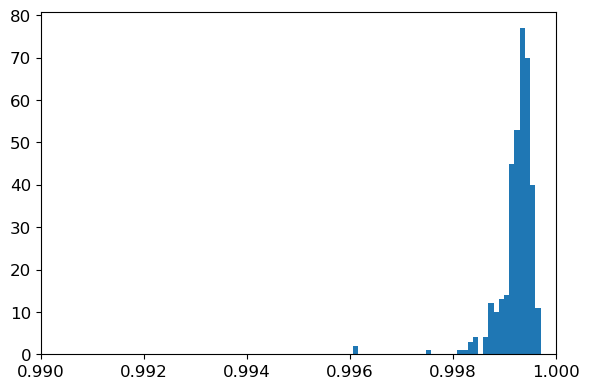

In [4]:
outdim=19*19/2
columns=[]
unlabeled_data=5000
#locat='5kdatamodels'
decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/FL_final/10kepochs/decoder_5000_0_22-46-50.pt'
data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')

training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000, normalize=True)
decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]), int(training_data.b[0].shape[0]))  #R^ {N_k} -> C^{N_rec*N_freq}
layers=[4096,2048]
encoder=M.fc_net_extra(int(training_data.b[0].shape[0]/2), layers,outdim*2, net_type='fc',linear_type='real', activation='leaky', bias=True, out_scaling=None,dropout=.5)
decoder.load_state_dict(torch.load(decoder_locats))
encoder.load_state_dict(torch.load(decoder_locats.replace('decoder', 'enocder')))
first_layer=encoder.layers[0]



Complex_eye=torch.cat((torch.eye(int(outdim*2)), torch.zeros((int(outdim*2),int(outdim*2)))), dim=1)
fig = plt.figure(figsize=(6, 4))


medium_hat=decoder(Complex_eye).squeeze()
medium_hat=F.normalize(medium_hat, dim=-1)
medium_hat=medium_hat.cpu().detach().numpy()
medium_hat=H.cat2complex(medium_hat)                    


max_inner_list=[]
maxG_inner_list=[]
index_list_list=[]

medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])

sum_max_inner_original=0      
torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
        #original way of computing inners
        # mean over true max over hats
index_list=[]
for i in range(19*19):
    if max(torch_inners[:, i])>.99 and i not in index_list:
        index_list.append(i)

    max_inner_list.append(max(torch_inners[i, :]))
    maxG_inner_list.append(max(torch_inners[:, i]))
    sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
max_avg_inners_original=sum_max_inner_original/400
index_list_list.append(index_list)


columns=medium_hat
columns=np.array(columns)
maxG_inner_list=np.array(maxG_inner_list)
max_inner_list=np.array(max_inner_list)


print('columns shape', columns.shape)
xmin=.99
xmax=1.0
counts, bins = np.histogram(max_inner_list, bins=np.linspace(xmin, xmax, 100))
#plt.title()
plt.hist(max_inner_list, bins=bins)
plt.xlim(xmin, xmax)

#plt.ylim(.7, 5)

#plt.stairs(counts, bins)
#plt.hlines(np.mean(counts), xmin=0, xmax=400, color='r')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)  # Add subticks to the y-axis
    #plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
plt.tight_layout()
plt.savefig(f"/home/achristie/Codes_data/Experiment_data/FL_histo.pdf")  # Save the figure as a PNG file



In [22]:
first_layer=encoder.layers[0]
W_0=first_layer.layer[0]
W_0=W_0.weight.data
W_0=F.normalize(W_0, dim=-1)
W_0=W_0.cpu().detach().numpy()
print(W_0.shape, sum(W_0[0]**2),W_0[0].shape)
W_0=H.cat2complex(W_0)
W_0=W_0
print(W_0.shape)



(8192, 1612) 0.9999999753734292 (1612,)
(8192, 806)


columns shape (8192, 806)


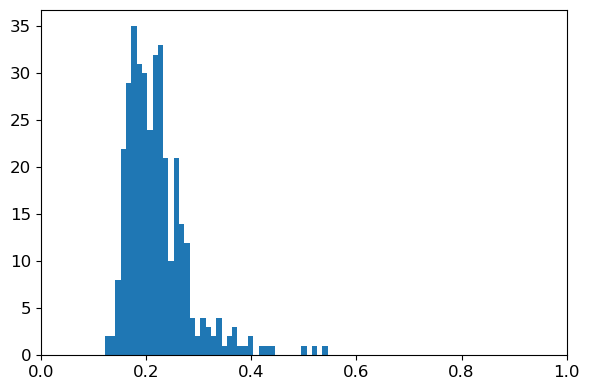

In [26]:

#W_0=first_layer[0]

#outdime=

#Complex_eye=torch.cat((torch.eye(int(outdim*2)), torch.zeros((int(outdim*2),int(outdim*2)))), dim=1)
first_layer=encoder.layers[0]
W_0=first_layer.layer[0]
W_0=W_0.weight.data
W_0=F.normalize(W_0, dim=-1)
W_0=W_0.cpu().detach().numpy()
print(W_0.shape, sum(W_0[0]**2),W_0[0].shape)
W_0=H.cat2complex(W_0)
W_0=W_0
print(W_0.shape)


fig = plt.figure(figsize=(6, 4))


medium_hat=W_0#decoder(Complex_eye).squeeze()
#medium_hat=F.normalize(medium_hat, dim=-1)
#medium_hat=medium_hat.cpu().detach().numpy()
#medium_hat=H.cat2complex(medium_hat)                    


max_inner_list=[]
maxG_inner_list=[]
index_list_list=[]

medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])

sum_max_inner_original=0      
torch_inners=np.abs(np.inner(medium_hat,medium.T.conj()) ) #entry i j is ghat_i dot bar(g_j) 
        #original way of computing inners
        # mean over true max over hats
index_list=[]
for i in range(19*19):
    if max(torch_inners[:, i])>.99 and i not in index_list:
        index_list.append(i)

    max_inner_list.append(max(torch_inners[i, :]))
    maxG_inner_list.append(max(torch_inners[:, i]))
    sum_max_inner_original=sum_max_inner_original+max(torch_inners[:, i])
max_avg_inners_original=sum_max_inner_original/400
index_list_list.append(index_list)


columns=medium_hat
columns=np.array(columns)
maxG_inner_list=np.array(maxG_inner_list)
max_inner_list=np.array(max_inner_list)


print('columns shape', columns.shape)
xmin=0
xmax=1.0
counts, bins = np.histogram(max_inner_list, bins=np.linspace(xmin, xmax, 100))
#plt.title()
plt.hist(max_inner_list, bins=bins)
plt.xlim(xmin, xmax)

#plt.ylim(.7, 5)

#plt.stairs(counts, bins)
#plt.hlines(np.mean(counts), xmin=0, xmax=400, color='r')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)  # Add subticks to the y-axis
    #plt.grid(axis='y', linestyle='dotted', which='both')  # Add subgridlines to the y-axis
plt.tight_layout()

In [3]:
#Notebooks for small tests
import os  
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
#imports and plotting function
import argparse
import mat73
import logging
import numpy as np
#import torchvision
from datetime import datetime
import os
import scipy.io
from torch.utils.data import DataLoader
import io
from PIL import Image
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import wandb
import math
import torch.nn.functional as F
import torchvision.transforms as T
import torch.nn as nn
import torch
import sys
import torch.optim.lr_scheduler as lr_scheduler
import wandb
import torch
from sklearn.preprocessing import StandardScaler
import Models as M
import Helpers as H
import time
import copy
from torch.func import vmap
from functorch.experimental import replace_all_batch_norm_modules_
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance_matrix
from sklearn.cluster import DBSCAN


%matplotlib inline

encoder_out='sigmoid'
cwd=os. getcwd()
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

data_path=os.path.join(cwd,'Data/FoldyLox_all_seeds/FoldyLox_seed0')
medium= np.array(mat73.loadmat(data_path+'/rtt.mat')['Artt'])
print(medium.shape)
inners=medium.transpose().conjugate()@medium
print(inners.shape)
coherence=0
for i in inners:
    for j in i:
        if abs(j)>coherence and j<.99:
            coherence=abs(j)
print('coherence of data: ', coherence)
#b=np.load(data_path+'/train/b.npy')
#rho=np.load(data_path+'/train/rho.npy')
#print(np.allclose(medium@rho[0],b[0]))
index_list=[]
unlabeled_data=5000
if False: #This vlock is from betas sweep. good betas. Not optimal.
    decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_0_'
    timescampstrs={'07-14-29','09-46-07','14-35-38','13-49-42','09-45-53'} #they located in above or below
    #            curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_1'+curr_decoder[-12:]



if True:#This block is from tests done with all default (pytorch) parameters


    decoder_locats='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Scaling_tests/10kepochs/decoder_5000_'
    timescampstrs = [
    "44_00-31-12",
    "47_00-31-10",
    "43_18-10-40",
    "46_18-10-39",
    "41_18-10-04",
    "49_18-00-09",
    "48_11-52-40",
    "45_11-50-38",
    "42_11-50-21",
    "40_11-49-46",
    "25_8-6-24",
    "24_01-54-27",
    "9_21-43-17",
    "4_21-42-58",
    "23_17-55-08",
    "29_15-29-37",
    "39_15-11-34",
    "34_15-09-31",
    "8_13-43-00",
    "3_13-42-41",
    "22_09-55-47",
    "38_08-50-47",
    "33_08-47-54",
    "28_08-46-30",
    "7_05-43-01",
    "2_05-42-47",
    "37_02-29-47",
    "32_2-26-51",
    "27_2-25-22",
    "21_01-56-27",
    "6_21-43-02",
    "1_21-42-47",
    "36_20-08-25",
    "31_20-05-29",
    "26_20-04-14",
    "20_17-57-14",
    "35_13-47-33",
    "30_13-44-32",
    "5_13-43-10",
    "0_13-42-53",
    "19_11-58-46",
    "18_8-27-31",
    "17_5-3-27",
    "16_01-39-09",
    "15_22-14-51",
    "14_17-34-09",
    "13_12-36-21",
    "12_9-12-21",
    "11_05-47-25",
    "10_1-9-58"
]

#,'21-52-00','01-44-08','05-09-23','01-48-20', '09-27-26','05-27-23','08-57-23','03-35-41'}


pixels='Gaussian_abs'


decoder_locats=[decoder_locats+timescampstr+'.pt' for timescampstr in timescampstrs]
training_data=H.data_rho_loaded(data_path+'/train',unlabeled_data/80000,pixels=pixels, normalize=False)
indim=int(training_data.b[0].shape[0]/2)
outdim=(training_data.rho[0].shape[0]/4)
def get_cluster_data(decoder_locats):
    Complex_eye=torch.cat((torch.eye(int(outdim*2)), torch.zeros((int(outdim*2),int(outdim*2)))), dim=1)

    #Complex_eye=torch.eye(400)#.to(device)
    columns=[]
    
    #decoder_locats=f'/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_locats = '/home/achristie/Codes_data/Experiment_data/rhosupport_stats/5khighcohdatamodels/'
    #decoder_files = [f for f in os.listdir(decoder_locats) if f.startswith('decoder')]
    for curr_decoder in decoder_locats:
        decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}

        #decoder=M.norm_linear_complex(int(training_data.rho[0].shape[0]/2), int(training_data.b[0].shape[0]), normalize=False)  #R^ {N_k} -> C^{N_rec*N_freq}
        try:
            decoder.load_state_dict(torch.load(curr_decoder))
        except:
            #curr_decoder='/home/achristie/Codes_data/Experiment_data/rhosupport_stats/Classic_gelma/decoder_5000_1'+curr_decoder[-12:]
            #decoder.load_state_dict(torch.load(curr_decoder))
            pass
        medium_hat=decoder(Complex_eye).squeeze()
        #print(medium_hat.shape)
        medium_hat=F.normalize(medium_hat, dim=-1)
        medium_hat=medium_hat.cpu().detach().numpy()
        medium_hat=H.cat2complex(medium_hat)                    
        columns.append(medium_hat)
    columns=np.array(columns)
    return  np.row_stack(columns)


col_list=get_cluster_data(decoder_locats)
print(f'shape of the union without removin: {col_list.shape}, number for Expceriments: {len(col_list)//361}')
for i in range(361):
    G_i=medium.T[i]
    print(G_i.shape)
    break

def db_inner(a,b):
    a=H.cat2complex(a)
    b=H.cat2complex(b)
    return 1-abs(np.inner(a,b.conj()))
X=col_list
X = np.concatenate([X.real, X.imag], axis=1)
perm=np.random.permutation(X.shape[0])
columns=X[perm] 
columns=columns[:50]
num_clusters=[]
#eps_linspace=np.linspace(2,.3,2)
for eps in [.25]:
    DBSCAN_fit=DBSCAN(eps=.25, min_samples=5, metric=db_inner).fit(X)
    DBSCAN_fit.labels_
    X_clustered=X[DBSCAN_fit.labels_!=-1]
    len(X_clustered)
    cluster_sizes=[len(X[DBSCAN_fit.labels_==i]) for i in range(max(DBSCAN_fit.labels_))]
    dist_in_cluster=[]
    for i in range(max(DBSCAN_fit.labels_)):
        X_in_cluster=X[DBSCAN_fit.labels_==i]
        dist_matrix=distance_matrix(X_in_cluster, X_in_cluster)
        max_dist_in_cluster=np.max(dist_matrix)
        #dist=sum((X_in_cluster[0]-X_in_cluster[1])**2)**(1/2)
        dist_in_cluster.append(max_dist_in_cluster)
    # if len(X[DBSCAN_fit.labels_==i])>1:
    #     dist_in_cluster.append(np.mean(np.sum((X[DBSCAN_fit.labels_==i]-np.mean(X[DBSCAN_fit.labels_==i], axis=0))**2, axis=1))
    # else:
    #     dist_in_cluster.append(0)
    dist_in_cluster#=[np.mean(np.sum((X[DBSCAN_fit.labels_==i]-np.mean(X[DBSCAN_fit.labels_==i], axis=0))**2, axis=1)) for i in range(max(DBSCAN_fit.labels_))]
    dist_in_cluster.sort()
    #plt.plot([i for i in range(len(dist_in_cluster))], dist_in_cluster)
    num_clusters.append(len(cluster_sizes))
    #print('largest cluster, number clustered (dbscan), number of clusters=: ',max(cluster_sizes), sum(cluster_sizes),len(cluster_sizes)) #Num of )
plt.plot(eps_linspace, num_clusters, label='DBSCAN number of clusters')
plt.hlines(19**2, eps_linspace[0],eps_linspace[-1], colors='r', linestyles='dashed', label='True number of columns')

(806, 361)
(361, 361)
coherence of data:  0.763143828697641
Medium: (806, 361), Rho: (5000, 361), B: (5000, 806)
shape of the union without removin: (18050, 806), number for Expceriments: 50
(806,)


KeyboardInterrupt: 

In [25]:
col_list=get_cluster_data(decoder_locats)

x=col_list
#X = np.concatenate([X.real, X.imag], axis=1)
perm=np.random.permutation(X.shape[0])
columns=X[perm] 
columns=columns[:50]
torch_inner=np.abs(1.0-(np.abs(np.inner(col_list,col_list.conj()))))
DBSCAN_fit=DBSCAN(eps=.25, min_samples=5, metric='precomputed').fit(torch_inner)



(18050, 18050)

: 

In [23]:
torch_inner=1-abs(np.abs(np.inner(col_list,col_list.conj())))
torch_inner.shape, torch_inner[:5]


((18050, 18050),
 array([[-1.1920929e-07,  9.7002810e-01,  9.7511274e-01, ...,
          9.6318048e-01,  9.8391575e-01,  9.6638685e-01],
        [ 9.7002810e-01, -1.1920929e-07,  9.7057629e-01, ...,
          9.7757465e-01,  9.5809674e-01,  9.9231303e-01],
        [ 9.7511274e-01,  9.7057629e-01,  0.0000000e+00, ...,
          9.2495978e-01,  9.3082011e-01,  9.8347384e-01],
        [ 9.6734136e-01,  9.7020292e-01,  9.0901482e-01, ...,
          9.6739531e-01,  9.6043849e-01,  9.5515001e-01],
        [ 9.8805618e-01,  9.6491462e-01,  8.6626691e-01, ...,
          9.8047096e-01,  9.5940387e-01,  9.6252644e-01]], dtype=float32))

In [19]:
test=np.array([54,.5,6])
np.min(test)

0.5